In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (silhouette_score, calinski_harabasz_score, davies_bouldin_score)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
)
import xgboost as xgb
import seaborn as sns

# Ignore warnings to keep notebook output clean
warnings.filterwarnings("ignore")

## Team Contribution Explanation

Our group of three collaboratively did this project using Google Colab. Although the final files was uploaded to GitHub by a single team member, this was done only because we faced repeated merge conflicts and version-control issues early in the project as well as setting up the repository in sfu's github server not allowing all the members to access it during the early stages. To avoid overwriting each other's work and to ensure everyone could see live updates, we agreed to work together through a shared Google Colab notebook instead of pushing multiple parallel commits. As a result, the GitHub commit history does not accurately show individual contributions. However, all members contributed equally to the development of the data preprocessing pipeline, the exploratory analysis, and the main notebook structure with everyone writing the corresponsing section in the report.

### Breakdown of Individual Contributions For the notebook.

- **Deep Bhimani**  
  - Preprocessing: column reduction and selection
  - Implemented: **K-Means++**, **Local Outlier Factor (LOF)**, **Random Forest Classifier**  

- **Niroshan Benjamin**  
  - Preprocessing: Data sampling and structing final data files
  - Implemented: **K-Medoids (PAM)**, **Clustering-Based methods**, **XGBoost**  

- **Ching Yan Wong**  
  - Preprocessing: handling missing values in the data
  - Implemented: **Hierarchical Clustering**, **Distance-Based methods**, **Logistic Regression**  


# Clustering


### K-Medoids

In [2]:
rand_seed = 42
np.random.seed(rand_seed)

X_pca = pd.read_csv("X_scaled_pca.csv")
y_data = pd.read_csv("y.csv")["y"].values
print(f"Data loaded: {X_pca.shape}, y: {y_data.shape}")

# Find optimal k
sil_scores = []
for k in range(2, 11):
    kmed = KMedoids(n_clusters=k, random_state=rand_seed, method='pam')

    clust_labels = kmed.fit_predict(X_pca)
    sil_sc = silhouette_score(X_pca, clust_labels)
    sil_scores.append(sil_sc)
    print(f"k={k}: {sil_sc:.4f}")

best_k = range(2, 11)[np.argmax(sil_scores)]
print(f"\nOptimal k: {best_k}")

Data loaded: (8848, 20), y: (8848,)
k=2: 0.1261
k=3: 0.0632
k=4: 0.0604
k=5: 0.0700
k=6: 0.0409
k=7: 0.0381
k=8: 0.0424
k=9: 0.0432
k=10: 0.0438

Optimal k: 2


K-Medoids clustering tested k=2 through k=10 clusters, with k=2 achieving the highest silhouette score (0.1261). However, all scores are low (<0.15), indicating weak clustering structure in the data. The silhouette score drops sharply from k=2 (0.126) to k=3 (0.063), suggesting the data naturally splits into two broad groups rather than multiple distinct clusters. This weak structure is typical for financial datasets where borrower characteristics exist on a continuum rather than forming discrete risk categories. The low scores indicate that distance-based clustering has limited ability to separate borrowers into well-defined groups.

In [3]:
# Fit final K-Medoids model
best_k = 2
print(f"K-Medoids (k={best_k}) Performance:")

kmed_model = KMedoids(n_clusters=best_k, random_state=rand_seed, method='pam')
labels = kmed_model.fit_predict(X_pca)

# Evaluation metrics
sil_sc = silhouette_score(X_pca, labels)
ch_sc = calinski_harabasz_score(X_pca, labels)
db_sc = davies_bouldin_score(X_pca, labels)
print(f"Silhouette: {sil_sc:.4f}")
print(f"Calinski-Harabasz: {ch_sc:.2f}")
print(f"Davies-Bouldin: {db_sc:.4f}")

# Cluster sizes
print(f"\nCluster distribution:")
for i in range(best_k):
    cnt = np.sum(labels == i)
    pct = cnt / len(labels) * 100
    def_rate = y_data[labels == i].mean() * 100
    print(f"Cluster {i}: {cnt} samples ({pct:.1f}%), default rate: {def_rate:.1f}%")

K-Medoids (k=2) Performance:
Silhouette: 0.1261
Calinski-Harabasz: 992.54
Davies-Bouldin: 2.7816

Cluster distribution:
Cluster 0: 5212 samples (58.9%), default rate: 20.4%
Cluster 1: 3636 samples (41.1%), default rate: 18.8%


The two clusters show balanced sizes (59% vs 41%) but minimal difference in default rates (20.4% vs 18.8%). The Davies-Bouldin score of 2.78 suggests moderate cluster separation. While K-Medoids successfully partitions the data, the small risk differential indicates that clustering alone may not be sufficient for credit risk segmentation.

Generating t-SNE visualization...


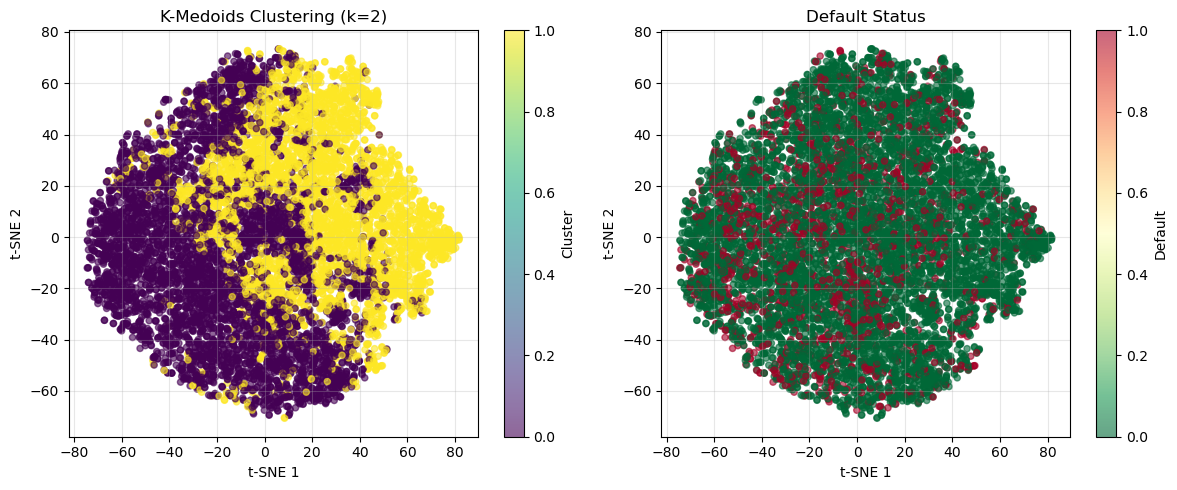

In [4]:
# t-SNE visualization
print("Generating t-SNE visualization...")
tsne_model = TSNE(n_components=2, random_state=rand_seed, perplexity=30)
X_embed = tsne_model.fit_transform(X_pca)

plt.figure(figsize=(12, 5))

# Clusters
plt.subplot(1, 2, 1)
sc = plt.scatter(X_embed[:, 0], X_embed[:, 1], c=labels, cmap='viridis', alpha=0.6, s=20)
plt.colorbar(sc, label='Cluster')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title(f'K-Medoids Clustering (k={best_k})')
plt.grid(True, alpha=0.3)

# Default status
plt.subplot(1, 2, 2)
sc = plt.scatter(X_embed[:, 0], X_embed[:, 1], c=y_data, cmap='RdYlGn_r', alpha=0.6, s=20)

plt.colorbar(sc, label='Default')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Default Status')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

The t-SNE visualization reveals two spatially distinct clusters (left plot), but the default distribution (right plot) shows that defaulted loans (red) are dispersed throughout both clusters rather than concentrated in one. This confirms that the clusters do not strongly align with loan outcomes, suggesting that default risk is influenced by complex feature interactions rather than simple geometric separation.

### K-Means++

In [5]:
# Data setup
DataFile = "X_scaled_pca.csv"
LabelFile = "y.csv"
OutputFolder = "kmeans_output"
os.makedirs(OutputFolder, exist_ok=True)

RANDOM_SEED = 42
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

print("KMeans++ Clustering Algorithm")

# 1) Loading data
print("1) Loading data")
X_scaled_pca = pd.read_csv(DataFile)
y = pd.read_csv(LabelFile)

print("Data shape:", X_scaled_pca.shape)
print("Preview of first 5 columns:", list(X_scaled_pca.columns[:5]))

# Showing class distribution of 0 (fully paid) or 1 (charged off)
ClassDist = y["y"].value_counts(normalize=True).round(3)
print("Normalized Class distribution:")
print(ClassDist.to_dict())

KMeans++ Clustering Algorithm
1) Loading data
Data shape: (8848, 20)
Preview of first 5 columns: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
Normalized Class distribution:
{0: 0.802, 1: 0.198}


The dataset has 8848 PCA scaled rows with a high imbalanced class distribution 80% being fully paid and 20% being charged off. This shows defaults are relativley rare. This imbalance kind of tells us that it is going to be difficult to clearly seperate high and low risk borrowers by clustering.

In [6]:
# 2) Feature selection with different top-n values
print("\n2) Feature selection with different top-n values")

# I am selecting few different numbers of PCs
feature_counts = [5, 8, 10, 12, 15, 20]
fs_results = []

for n_features in feature_counts:
    # Am Selecting n PCA components
    X_tmp = X_scaled_pca.iloc[:, :n_features].values

    kmeanstmp = KMeans(
        n_clusters=2,
        init="k-means++",
        random_state=RANDOM_SEED,
        n_init=10
    )
    labelstmp = kmeanstmp.fit_predict(X_tmp)

    SillScore= silhouette_score(X_tmp, labelstmp)
    ChScore = calinski_harabasz_score(X_tmp, labelstmp)
    DbScore =davies_bouldin_score(X_tmp, labelstmp)

    fs_results.append([n_features, SillScore, ChScore, DbScore])
    print(f"n={n_features}: Silhouette={SillScore:.4f}, CH={ChScore:.2f}, DB={DbScore:.4f}")

fs_df = pd.DataFrame(
    fs_results,
    columns=["n_features", "silhouette", "calinski_harabasz", "davies_bouldin"]
)

best_row_idx = fs_df["silhouette"].idxmax()
best_n_features = int(fs_df.loc[best_row_idx, "n_features"])
print(f"Best number of PCA components: {best_n_features}")

# Useing the best number of PCA components
X_selected = X_scaled_pca.iloc[:, :best_n_features].values
selected_cols= X_scaled_pca.columns[:best_n_features].tolist()
print("Selected PCA columns:")
print(selected_cols)



2) Feature selection with different top-n values
n=5: Silhouette=0.2748, CH=2273.17, DB=1.7237
n=8: Silhouette=0.2390, CH=1766.36, DB=1.9321
n=10: Silhouette=0.2262, CH=1592.65, DB=2.0436
n=12: Silhouette=0.2138, CH=1472.42, DB=2.1402
n=15: Silhouette=0.2053, CH=1363.31, DB=2.2331
n=20: Silhouette=0.1931, CH=1253.02, DB=2.3371
Best number of PCA components: 5
Selected PCA columns:
['PC1', 'PC2', 'PC3', 'PC4', 'PC5']


We are going to use 5 PCA components that give us the strongest clustering performance based on the highest silhouette score of 0.2748 and the lowest DB score been different n values. This shows that the first 5 PC features capture the most useful structure/information for seperating patterns in the data.


3) Elbow method, k selection
k=2: Silhouette=0.2748, CH=2273.17, DB=1.7237
k=3: Silhouette=0.2003, CH=2220.90, DB=1.5746
k=4: Silhouette=0.1980, CH=2061.49, DB=1.4672
k=5: Silhouette=0.2048, CH=2011.79, DB=1.3709
k=6: Silhouette=0.1764, CH=1811.93, DB=1.4515
k=7: Silhouette=0.1631, CH=1674.74, DB=1.5702
k=8: Silhouette=0.1647, CH=1567.41, DB=1.5238
k=9: Silhouette=0.1570, CH=1487.57, DB=1.5227
k=10: Silhouette=0.1521, CH=1416.66, DB=1.5455


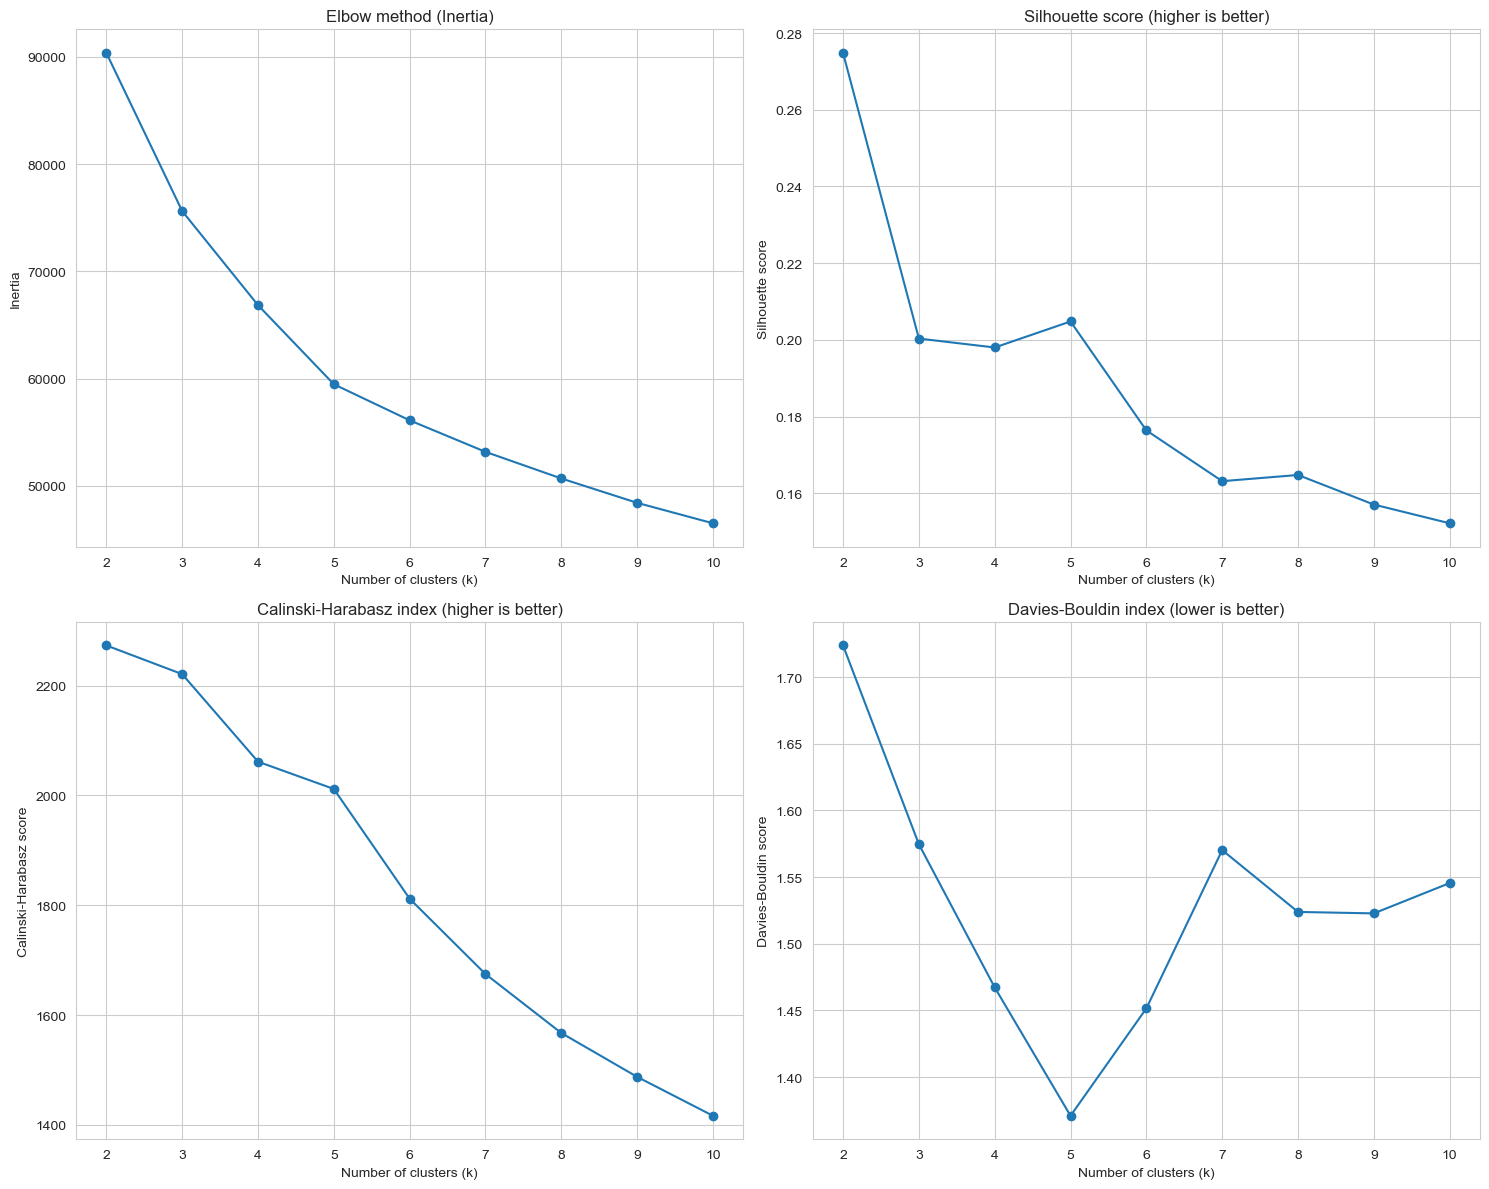

Best K value based on silhouette: k = 2


In [7]:
# 3) Elbow method, k selection
print("\n3) Elbow method, k selection")
k_values = list(range(2, 11))
inertias = []
silhouette_scores = []
calinski_scores = []
davies_scores = []

for k in k_values:
    kmeans = KMeans(
        n_clusters=k,
        init="k-means++",
        random_state=RANDOM_SEED,
        n_init=10,
        max_iter=300
    )
    k_labels = kmeans.fit_predict(X_selected)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_selected, k_labels))
    calinski_scores.append(calinski_harabasz_score(X_selected, k_labels))
    davies_scores.append(davies_bouldin_score(X_selected, k_labels))

    print(
        f"k={k}: "
        f"Silhouette={silhouette_scores[-1]:.4f}, "
        f"CH={calinski_scores[-1]:.2f}, "
        f"DB={davies_scores[-1]:.4f}"
    )

# Visualize the findings for elbow and other evaluations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].plot(k_values, inertias, marker="o")
axes[0, 0].set_xlabel("Number of clusters (k)")
axes[0, 0].set_ylabel("Inertia")
axes[0, 0].set_title("Elbow method (Inertia)")

axes[0, 1].plot(k_values, silhouette_scores, marker="o")
axes[0, 1].set_xlabel("Number of clusters (k)")
axes[0, 1].set_ylabel("Silhouette score")
axes[0, 1].set_title("Silhouette score (higher is better)")

axes[1, 0].plot(k_values, calinski_scores, marker="o")
axes[1, 0].set_xlabel("Number of clusters (k)")
axes[1, 0].set_ylabel("Calinski-Harabasz score")
axes[1, 0].set_title("Calinski-Harabasz index (higher is better)")

axes[1, 1].plot(k_values, davies_scores, marker="o")
axes[1, 1].set_xlabel("Number of clusters (k)")
axes[1, 1].set_ylabel("Davies-Bouldin score")
axes[1, 1].set_title("Davies-Bouldin index (lower is better)")

plt.tight_layout()
plt.show()

elbow_path = os.path.join(OutputFolder, "elbow_method.png")
fig.savefig(elbow_path, dpi=300, bbox_inches="tight")

# I am selecting the best k based on max silhouette score
best_k_idx = int(np.argmax(silhouette_scores))
best_k = k_values[best_k_idx]
print(f"Best K value based on silhouette: k = {best_k}")


After testing k=2 to k=10, the inertia and CH index both drop slowly but the silhouette score peaks at k=2 at 0.276. Since we are more familiar with the silhouette score from the assignments, we selected to go with k=2 based on the silhouette score. Overall the metrics show that two clusters can capture the main structure in the data but the seperation could be very close by based on the low silhouette score.

In [8]:
# 4) KMeans++ Clustering
print(f"\n4) KMeans++ Clustering with k = {best_k}")
kmeans_final = KMeans(
    n_clusters=best_k,
    init="k-means++",
    random_state=RANDOM_SEED,
    n_init=10,
    max_iter=300
)
cluster_labels = kmeans_final.fit_predict(X_selected)

cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print("Cluster sizes:")
for cid, cnt in cluster_counts.items():
    pct = 100.0 * cnt / len(cluster_labels)
    print(f"Cluster {cid}: {cnt} samples ({pct:.2f}%)")



4) KMeans++ Clustering with k = 2
Cluster sizes:
Cluster 0: 2325 samples (26.28%)
Cluster 1: 6523 samples (73.72%)


THe clustering algorithm splits the data into 2 clusters, one containing about 74% of the sample and the other only 26%. This shows that the dataset's structure is dominated by one large dense group. This shows that even tho k=2 is ideal/optimal, the clusters are not equally defined.

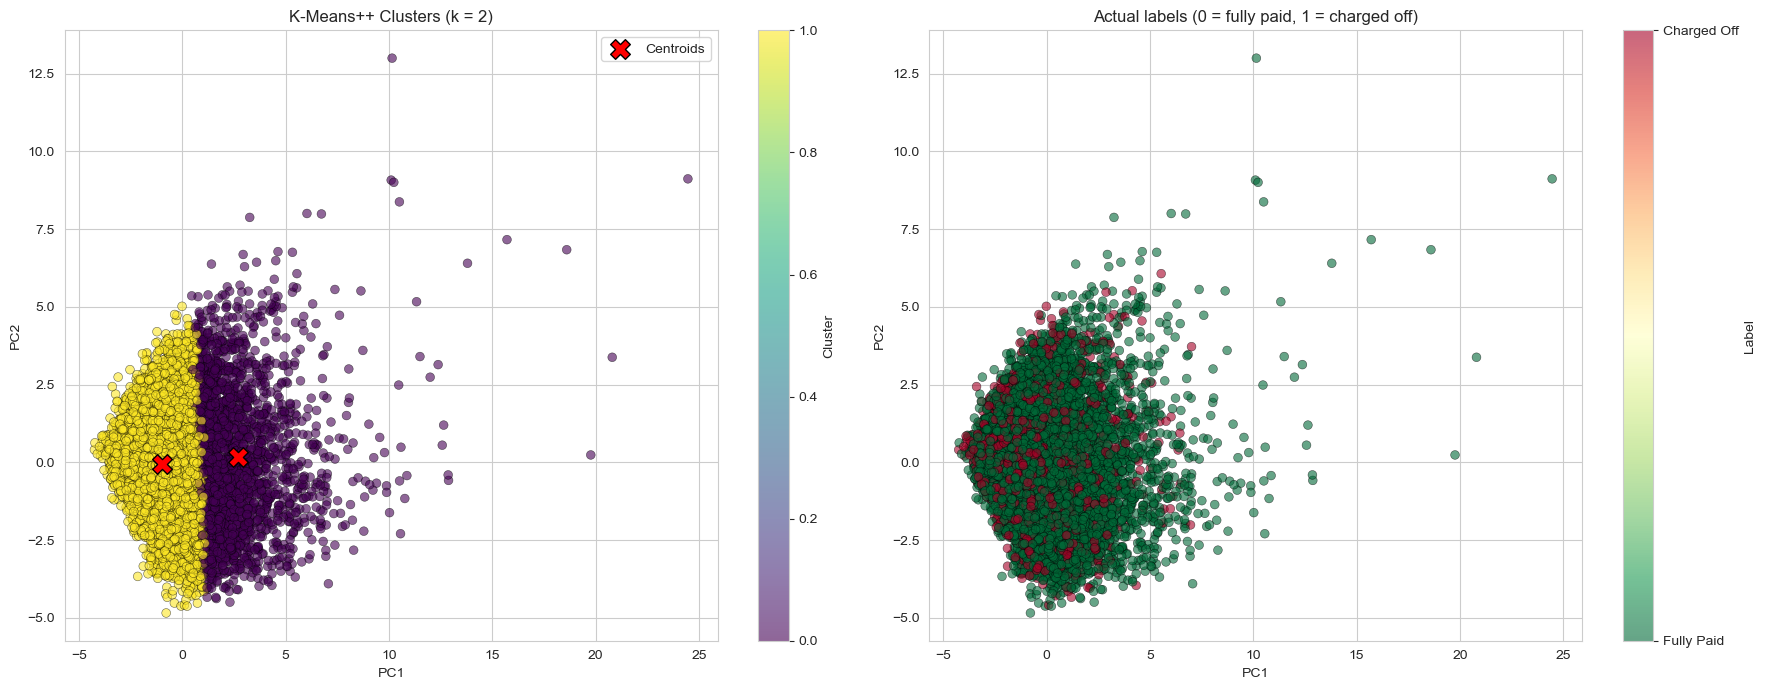

In [9]:
# 5) Visualizing PCA 2D and 3D plots

pca_2d = PCA(n_components=2, random_state=RANDOM_SEED)
X_2d = pca_2d.fit_transform(X_selected)
pca_3d = PCA(n_components=3, random_state=RANDOM_SEED)
X_3d = pca_3d.fit_transform(X_selected)

# 2D plots clusters vs actual labels
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# clusters
sc1 = axes[0].scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=cluster_labels,
    cmap="viridis",
    alpha=0.6,
    s=40,
    edgecolors="k",
    linewidth=0.4
)
centers_2d = pca_2d.transform(kmeans_final.cluster_centers_)
axes[0].scatter(
    centers_2d[:, 0],
    centers_2d[:, 1],
    c="red",
    marker="X",
    s=200,
    edgecolors="black",
    linewidth=1.0,
    label="Centroids"
)
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].set_title(f"K-Means++ Clusters (k = {best_k})")
axes[0].legend()
plt.colorbar(sc1, ax=axes[0], label="Cluster")

# actual labels
sc2 = axes[1].scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=y["y"].values,
    cmap="RdYlGn_r",
    alpha=0.6,
    s=40,
    edgecolors="k",
    linewidth=0.4
)
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
axes[1].set_title("Actual labels (0 = fully paid, 1 = charged off)")
cbar2 = plt.colorbar(sc2, ax=axes[1], label="Label", ticks=[0, 1])
cbar2.set_ticklabels(["Fully Paid", "Charged Off"])

plt.tight_layout()
plt.show()

clusters_2d_path = os.path.join(OutputFolder, "clusters_2d.png")
fig.savefig(clusters_2d_path, dpi=300, bbox_inches="tight")


The 2D scatter plots shows what the kmeans++ algorithm shows. THere are 2 seperable gemetric clusters shown in yellow and purple with their centroids shown. The true defaults labels are heavily mixed accross both groups, it looks like charged off points are usually more towards the dense area and the fully paid are in the dense areas and more scattered. This tells dones not help us that much when it comes to clearly seeing the seperation between customer profiles who fully pay or get charged off.

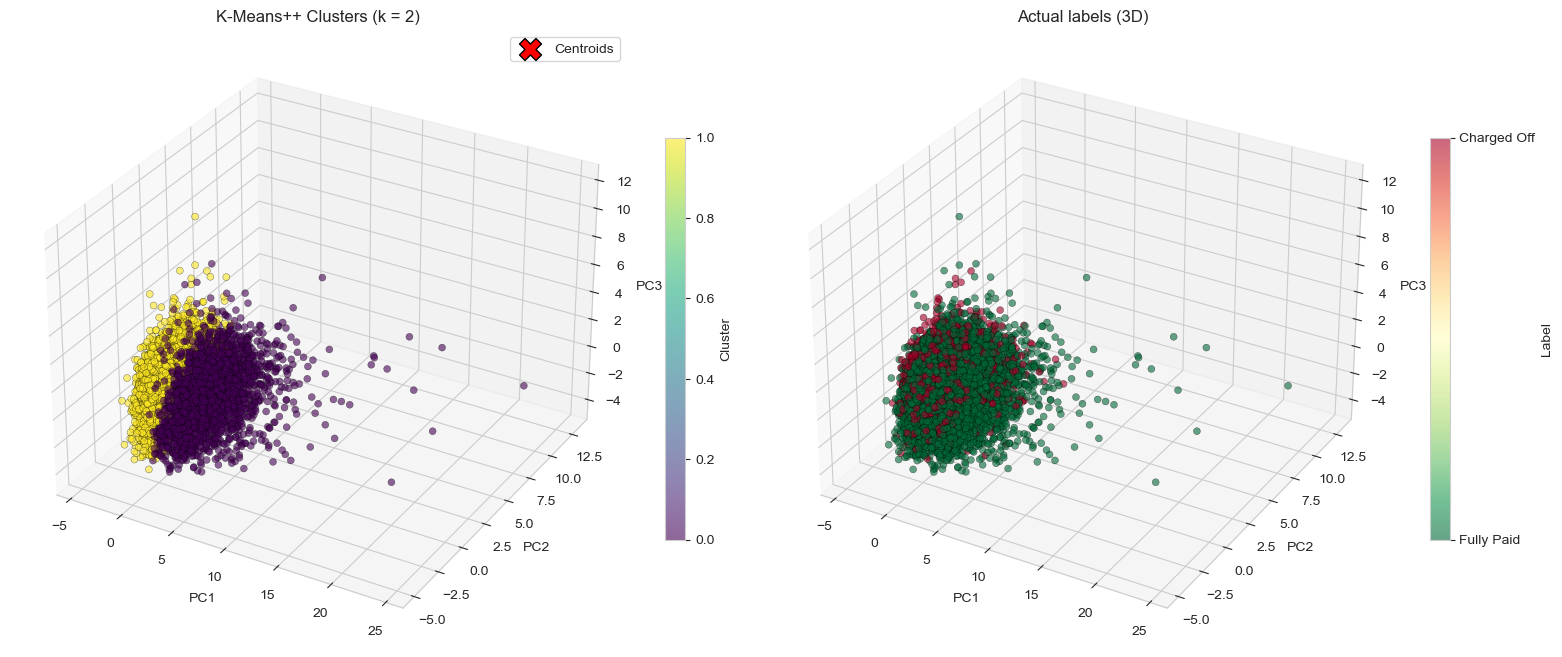

In [10]:
fig = plt.figure(figsize=(16, 7))

ax1 = fig.add_subplot(121, projection="3d")
sc3 = ax1.scatter(
    X_3d[:, 0],
    X_3d[:, 1],
    X_3d[:, 2],
    c=cluster_labels,
    cmap="viridis",
    alpha=0.6,
    s=25,
    edgecolors="k",
    linewidth=0.3
)
centers_3d = pca_3d.transform(kmeans_final.cluster_centers_)
ax1.scatter(
    centers_3d[:, 0],
    centers_3d[:, 1],
    centers_3d[:, 2],
    c="red",
    marker="X",
    s=250,
    edgecolors="black",
    linewidth=1.0,
    label="Centroids"
)
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_zlabel("PC3")
ax1.set_title(f"K-Means++ Clusters (k = {best_k})")
ax1.legend()
plt.colorbar(sc3, ax=ax1, label="Cluster", shrink=0.6)

ax2 = fig.add_subplot(122, projection="3d")
sc4 = ax2.scatter(
    X_3d[:, 0],
    X_3d[:, 1],
    X_3d[:, 2],
    c=y["y"].values,
    cmap="RdYlGn_r",
    alpha=0.6,
    s=25,
    edgecolors="k",
    linewidth=0.3
)
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.set_zlabel("PC3")
ax2.set_title("Actual labels (3D)")
cbar4 = plt.colorbar(sc4, ax=ax2, label="Label", shrink=0.6, ticks=[0, 1])
cbar4.set_ticklabels(["Fully Paid", "Charged Off"])

plt.tight_layout()
plt.show()

clusters_3d_path = os.path.join(OutputFolder, "clusters_3d.png")
fig.savefig(clusters_3d_path, dpi=300, bbox_inches="tight")


In [11]:
# 6) Cluster vs actual label analysis
print("\n6) Cluster vs actual label analysis")
analysis_df = pd.DataFrame({
    "Cluster": cluster_labels,
    "Actual_Label": y["y"].values
})

crosstab = pd.crosstab(analysis_df["Cluster"], analysis_df["Actual_Label"])
print("Cluster vs Actual Label (counts):")
print(crosstab)

print("\nCharged Off percentage by cluster:")
for cid in sorted(analysis_df["Cluster"].unique()):
    cluster_slice = analysis_df[analysis_df["Cluster"] == cid]
    charged_off_pct = 100.0 * cluster_slice["Actual_Label"].sum() / len(cluster_slice)
    print(f"Cluster {cid}: {charged_off_pct:.2f}% Charged Off")

print("\nDone!")



6) Cluster vs actual label analysis
Cluster vs Actual Label (counts):
Actual_Label     0     1
Cluster                 
0             2016   309
1             5084  1439

Charged Off percentage by cluster:
Cluster 0: 13.29% Charged Off
Cluster 1: 22.06% Charged Off

Done!


To conclude the K-means++ algorithm found k=2 is gives us the best clustering quality with the first 5 PCA features giving the strongest seperation. The final clusters were in uneven sizes 74%-24%. The clusters are very close to each other seperated by a verticle line as seen in the 2D and 3D plots. The actual loan outcomes are mixed across both cluster groups. One clustering group had 13.29% of charged off cases while the other had 22%. This shows that the clusters have some variation in borrower behavior but not clear high vs low risk segments. Overall the model identifies the structural grouping in the data, but the clusterings have limited value of meaninful credit risk segmentation.

### Hierarchical

In [12]:
# Load data
X = pd.read_csv("X_scaled_pca.csv")

# target: 0 = Fully Paid, 1 = Charged Off
y = pd.read_csv("y.csv").values.ravel()

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (8848, 20)
y shape: (8848,)


In [13]:
# Try different numbers of clusters
results = []

for k in range(2, 11):  # k = 2..10
    model = AgglomerativeClustering(
        n_clusters=k,
        linkage="ward"   # uses Euclidean distance internally
    )
    labels_k = model.fit_predict(X)

    sil = silhouette_score(X, labels_k)
    ch = calinski_harabasz_score(X, labels_k)
    db = davies_bouldin_score(X, labels_k)

    results.append({
        "k": k,
        "silhouette": sil,
        "calinski_harabasz": ch,
        "davies_bouldin": db
    })

df_res = pd.DataFrame(results)
print(df_res)

    k  silhouette  calinski_harabasz  davies_bouldin
0   2    0.225458         838.627067        2.378383
1   3    0.072965         810.353183        2.649131
2   4    0.080964         715.159953        2.376453
3   5    0.080670         661.411629        1.921353
4   6    0.068429         613.369180        2.074479
5   7    0.037265         571.602463        2.331997
6   8    0.010631         527.792555        2.342729
7   9    0.012449         494.354492        2.586160
8  10    0.005970         468.499059        2.575850


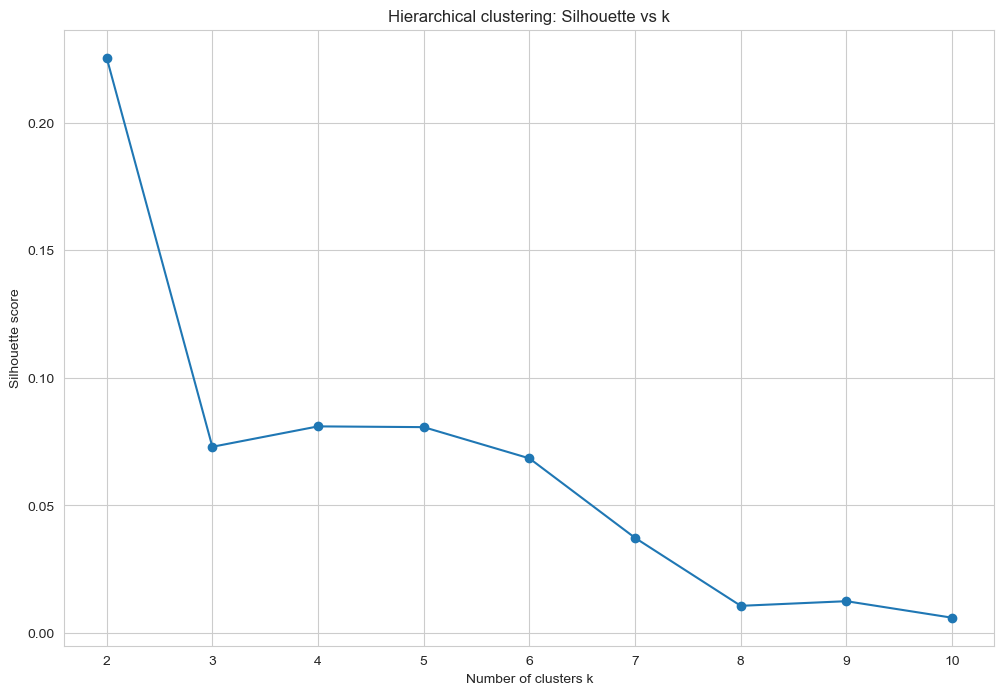

Chosen k_best: 2


In [14]:
# Plot silhouette vs k to choose k_best
plt.plot(df_res["k"], df_res["silhouette"], marker="o")
plt.xlabel("Number of clusters k")
plt.ylabel("Silhouette score")
plt.title("Hierarchical clustering: Silhouette vs k")
plt.grid(True)
plt.show()

# Choose k_best based on the printed table / plot
k_best = int(df_res.loc[df_res["silhouette"].idxmax(), "k"])
print("Chosen k_best:", k_best)

We tried k from 2 to 10. The silhouette score is clearly highest at k = 2 (0.225). For k ≥ 3, the silhouette score drops a lot to around 0.08 or lower, so those clusterings are much worse. The Calinski–Harabasz score is also highest at k = 2 and slowly goes down as k increases. The Davies–Bouldin index is lowest at k = 5, but the silhouette score there is still much worse than at k = 2. Because of this, k = 2 still gives the best and cleanest clustering, so we use k = 2 for our final hierarchical model.

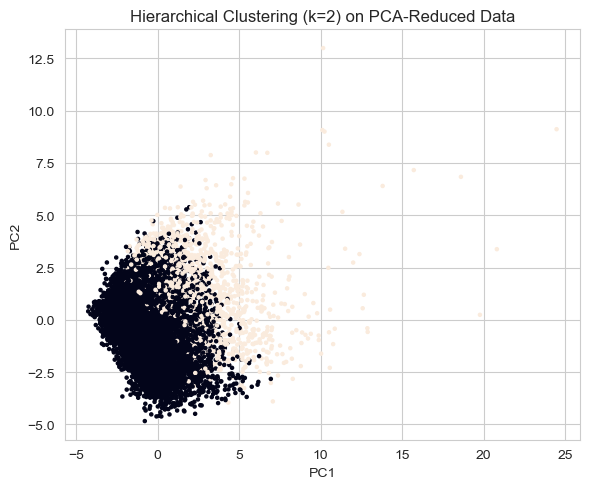

In [15]:
# Fit final model with k_best
final_model = AgglomerativeClustering(
    n_clusters=k_best,
    linkage="ward"
)
h_labels = final_model.fit_predict(X)

# 2D visualization using PCA
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X)

plt.figure(figsize=(6, 5))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=h_labels, s=5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"Hierarchical Clustering (k={k_best}) on PCA-Reduced Data")
plt.tight_layout()
plt.show()

With k = 2, the PCA plot shows two groups that overlap but are still somewhat separated. One cluster is mainly on the left (smaller PC1 values), and the other spreads more to the right. This means the hierarchical method finds some structure in the borrowers, but the clusters are not perfectly clean.

In [16]:
# Relate clusters to default labels
contingency = pd.crosstab(h_labels, y, rownames=["cluster"], colnames=["Charged Off"])
print("\nCluster vs Charged Off contingency table:")
print(contingency)


Cluster vs Charged Off contingency table:
Charged Off     0     1
cluster                
0            6002  1565
1            1098   183


Cluster 0 has 6002 Fully Paid and 1565 Charged Off loans, so the default rate is about 20.7%. Cluster 1 has 1098 Fully Paid and 183 Charged Off loans, so the default rate is about 14.3%. The whole dataset has a default rate of about 19.8%. So Cluster 0 is a bit riskier than average, and Cluster 1 is safer. This shows that hierarchical clustering can roughly separate higher-risk and lower-risk borrowers even without using the labels. However, the difference is still small (about 6 percentage points), so hierarchical clustering is only partially useful for risk segmentation and cannot fully separate high-risk and low-risk borrowers.

# Outlier Detection

### Clustering-Based

In [17]:
# Calculate distance to cluster medoid
medoids = kmed_model.cluster_centers_
dist_to_medoid = np.zeros(len(X_pca))

for i in range(len(X_pca)):
    clust = labels[i]
    medoid = medoids[clust]
    dist_to_medoid[i] = np.linalg.norm(X_pca.iloc[i].values - medoid)

# Define outliers (95th percentile threshold)
thresh = np.percentile(dist_to_medoid, 95)
is_outlier = dist_to_medoid > thresh

print(f"Outlier Detection Results:")
print(f"Threshold (95th percentile): {thresh:.4f}")
print(f"Outliers: {np.sum(is_outlier)} ({np.sum(is_outlier)/len(is_outlier)*100:.1f}%)")
print(f"Inliers: {np.sum(~is_outlier)} ({np.sum(~is_outlier)/len(is_outlier)*100:.1f}%)")

print(f"\nDefault rates:")
print(f"Outliers: {y_data[is_outlier].mean()*100:.1f}%")
print(f"Inliers: {y_data[~is_outlier].mean()*100:.1f}%")
print(f"Overall: {y_data.mean()*100:.1f}%")

Outlier Detection Results:
Threshold (95th percentile): 6.5833
Outliers: 443 (5.0%)
Inliers: 8405 (95.0%)

Default rates:
Outliers: 13.1%
Inliers: 20.1%
Overall: 19.8%


Using the 95th percentile distance threshold (6.58), we identified 443 outliers (5.0% of data) that are far from their cluster medoids. Counterintuitively, outliers exhibit a significantly lower default rate (13.1%) compared to inliers (20.1%), a 7 percentage point difference. This indicates outliers are not erroneous data or high-risk anomalies, but rather legitimate low-risk borrowers with atypical feature combinations.Since outliers contain valuable information about creditworthy non-traditional borrowers and show lower risk than the overall population (13.1% vs 19.8% overall default rate), we retain all outliers for classification to preserve model generalizability.

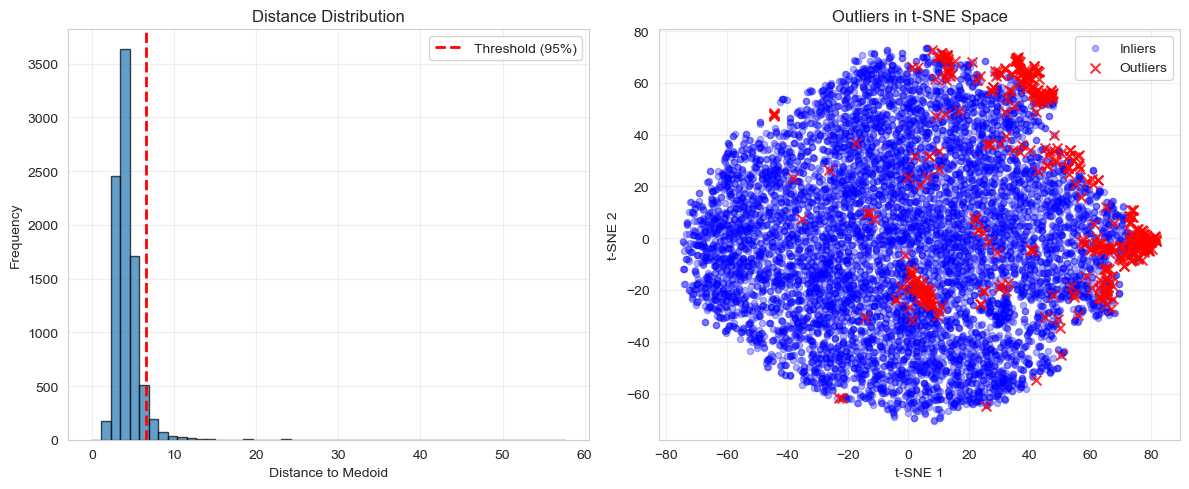

In [18]:
# Visualize outliers
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1 Distance distribution
axes[0].hist(dist_to_medoid, bins=50, alpha=0.7, edgecolor='black')
axes[0].axvline(thresh, color='r', linestyle='--', linewidth=2, label='Threshold (95%)')
axes[0].set_xlabel('Distance to Medoid')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distance Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2 Outliers in t-SNE space
axes[1].scatter(X_embed[~is_outlier, 0], X_embed[~is_outlier, 1],
                c='blue', alpha=0.3, s=20, label='Inliers')
axes[1].scatter(X_embed[is_outlier, 0], X_embed[is_outlier, 1],
                c='red', alpha=0.8, s=50, marker='x', label='Outliers')
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].set_title('Outliers in t-SNE Space')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Most samples cluster near their medoids, with outliers scattered around cluster peripheries in t-SNE space. Outliers show a lower default rate (13.1% vs 20.1%), indicating they represent valid low-risk borrowers with atypical profiles rather than noise. Decision: Keep outliers for classification.

### Local Outlier Factor


In [19]:
# Data setup
DataFile = "X_scaled_pca.csv"
LabelFile = "y.csv"
OutputFolder = "lof_output"
os.makedirs(OutputFolder, exist_ok=True)

# Iterating through N neighbors
N_neighborOptions = [10, 20, 30, 40, 50, 60, 80, 100]

# LOF thresholds
ModerateOutlier = 1.5
StrongOutlier = 2.0

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

print("\nLocal Outlier Factor (LOF) Outlier Detection Algorithm")


Local Outlier Factor (LOF) Outlier Detection Algorithm


In [20]:
print("1) Loading data")

X_scaled_pca = pd.read_csv(DataFile)
y_df = pd.read_csv(LabelFile)

y_values = y_df["y"].values
X_data = X_scaled_pca.values

n_samples, n_features = X_data.shape

print("X shape:", X_scaled_pca.shape)
print("Samples:", n_samples, "Features (PCA):", n_features)


1) Loading data
X shape: (8848, 20)
Samples: 8848 Features (PCA): 20


The dataset has 8848 samples and 20 PCA scaled features. This gives the baseline structure for finding outliers with LOF.

In [21]:
print("\n2) Tuning N neighbors based on LOF scores")

results = []

for n_neighbors in N_neighborOptions:
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination="auto", novelty=False)
    _ = lof.fit_predict(X_data)
    lof_scores = -lof.negative_outlier_factor_

    moderate_mask = lof_scores > ModerateOutlier
    strong_mask = lof_scores > StrongOutlier

    n_moderate = int(moderate_mask.sum())
    n_strong = int(strong_mask.sum())

    frac_moderate = 100.0 * n_moderate / n_samples
    frac_strong = 100.0 * n_strong / n_samples

    # Inliers
    inlier_scores = lof_scores[lof_scores <= 1.2]
    outlier_scores = lof_scores[lof_scores > ModerateOutlier]

    if len(inlier_scores) > 0:
        mean_inlier = float(inlier_scores.mean())
        std_inlier = float(inlier_scores.std() + 1e-6)
    else:
        mean_inlier = 1.0
        std_inlier = 1e-6

    if len(outlier_scores) > 0:
        mean_outlier = float(outlier_scores.mean())
    else:
        mean_outlier = mean_inlier

    quality = (mean_outlier - mean_inlier) / std_inlier

    results.append({
        "n_neighbors": n_neighbors,
        "n_moderate": n_moderate,
        "n_strong": n_strong,
        "frac_moderate": frac_moderate,
        "frac_strong": frac_strong,
        "mean_inlier": mean_inlier,
        "mean_outlier": mean_outlier,
        "quality": quality,
    })

    print(
        f"n={n_neighbors:3d}: "
        f"moderate={n_moderate:4d} ({frac_moderate:4.2f}%), "
        f"strong={n_strong:4d} ({frac_strong:4.2f}%), "
        f"quality={quality:6.2f}"
    )

results_df = pd.DataFrame(results)
results_df



2) Tuning N neighbors based on LOF scores
n= 10: moderate=  30 (0.34%), strong=   3 (0.03%), quality= 27.43
n= 20: moderate=  40 (0.45%), strong=   5 (0.06%), quality= 26.25
n= 30: moderate=  46 (0.52%), strong=  10 (0.11%), quality= 25.86
n= 40: moderate=  52 (0.59%), strong=  12 (0.14%), quality= 25.05
n= 50: moderate=  62 (0.70%), strong=  13 (0.15%), quality= 23.12
n= 60: moderate=  65 (0.73%), strong=  14 (0.16%), quality= 23.03
n= 80: moderate=  73 (0.83%), strong=  17 (0.19%), quality= 22.24
n=100: moderate=  83 (0.94%), strong=  18 (0.20%), quality= 21.09


,n_neighbors,n_moderate,n_strong,frac_moderate,frac_strong,mean_inlier,mean_outlier,quality
0,10,30,3,0.339060,0.033906,1.066109,2.496754,27.431497
1,20,40,5,0.452080,0.056510,1.066018,2.427965,26.254042
2,30,46,10,0.519892,0.113020,1.065573,2.407114,25.858049
3,40,52,12,0.587703,0.135624,1.065114,2.373950,25.048056
4,50,62,13,0.700723,0.146926,1.064823,2.280446,23.118596
5,60,65,14,0.734629,0.158228,1.064757,2.287995,23.025677
6,80,73,17,0.825045,0.192134,1.064147,2.254098,22.243155
7,100,83,18,0.938065,0.203436,1.063950,2.203772,21.086756


The LOF tuning results tell us that as the number of neighbors increase, the number of outliers slowly increase as well. The seperation quality between the outliers and the inlines declines stedily from 27.4 to 21.2 for k=10 to k=100. This shows that smaller neighbor hood sizes around 10-30 produce the clearest seperation between normal and unusual borrowers, givning us a better results for LOF.

In [22]:
valid = results_df[
    (results_df["frac_moderate"] >= 0.5) &
    (results_df["frac_moderate"] <= 5.0) &
    (results_df["n_strong"] >= 10)
]

if len(valid) > 0:
    best_idx = valid["quality"].idxmax()
else:
    best_idx = results_df["quality"].idxmax()

best_n_neighbors = int(results_df.loc[best_idx, "n_neighbors"])
print("Selected N neighbors:", best_n_neighbors)


Selected N neighbors: 30


We select 30 neighbors for LOF as it satisfies the desired outlier proportion constraints while getting the highest seperation quality compared to other neighbor values we had above. 30 neighbors give us a balanced and reliable size for detecting meaningful outliers.


3) Visualizing hyperparameter behavior


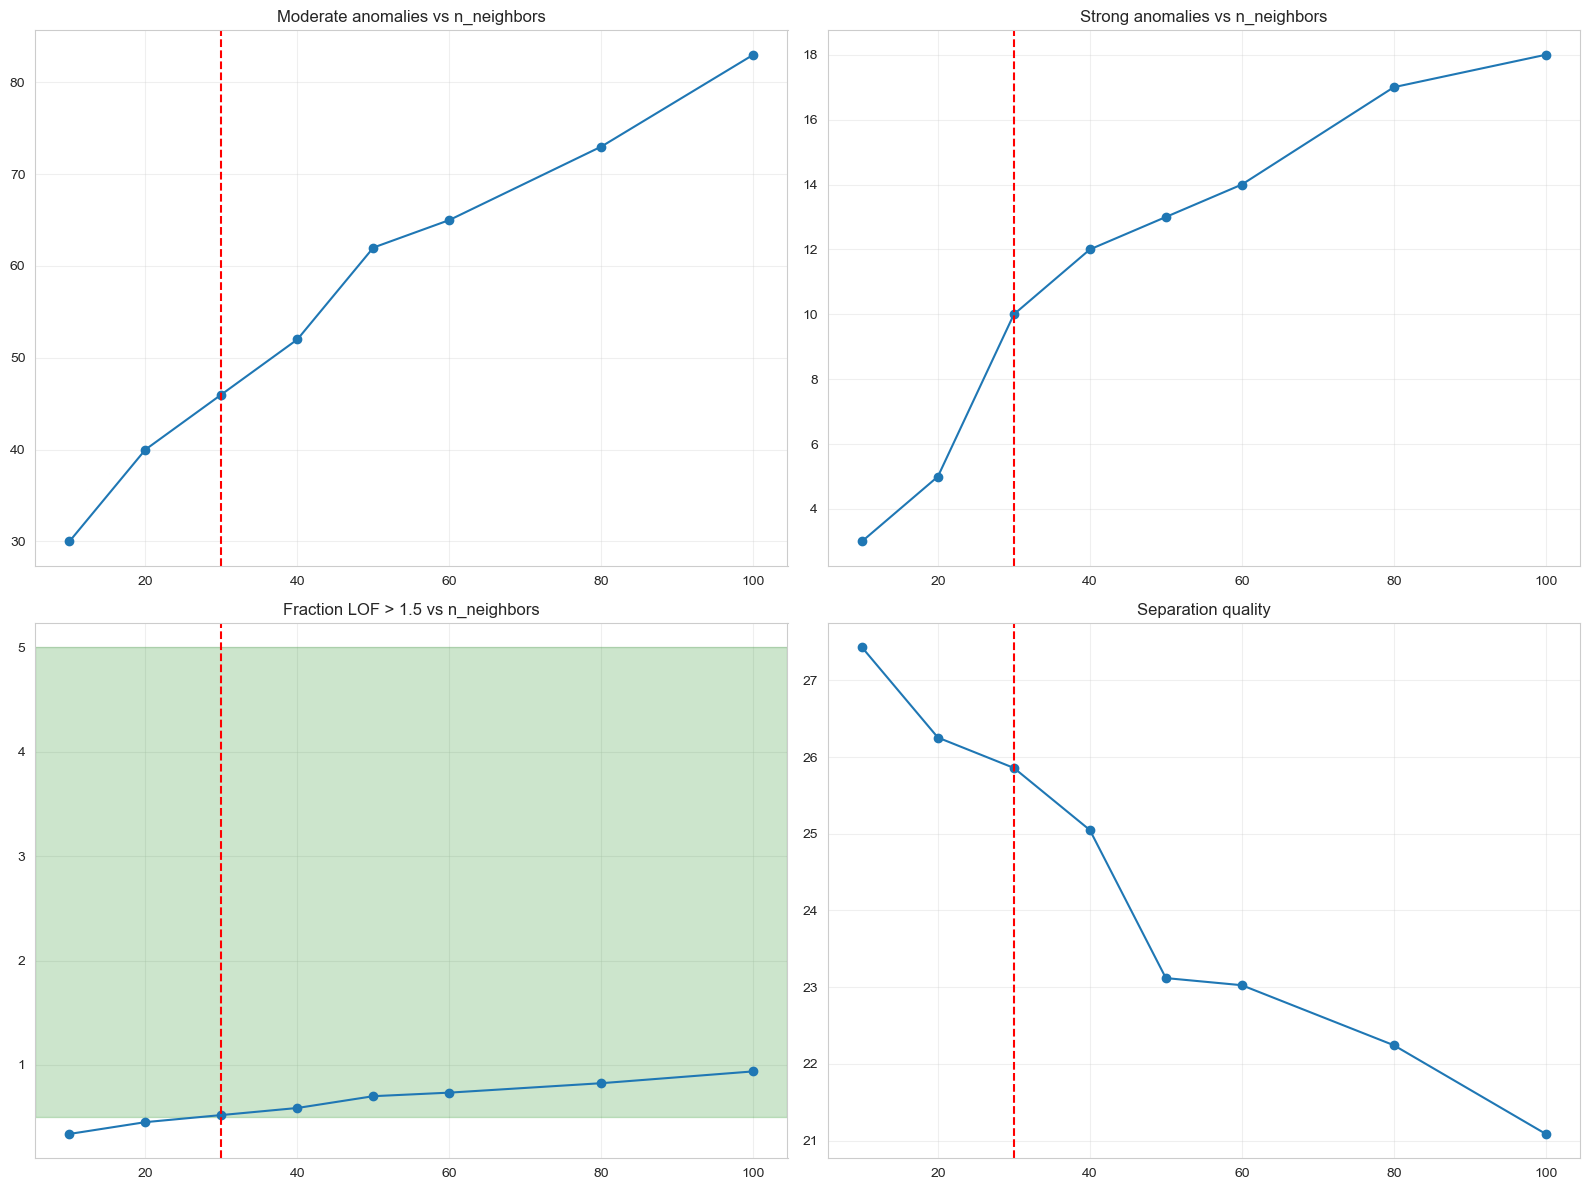

In [23]:
print("\n3) Visualizing hyperparameter behavior")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Moderate anomalies
axes[0, 0].plot(results_df["n_neighbors"], results_df["n_moderate"], marker="o")
axes[0, 0].axvline(best_n_neighbors, color="red", linestyle="--")
axes[0, 0].set_title("Moderate anomalies vs n_neighbors")
axes[0, 0].grid(True, alpha=0.3)

# Strong anomalies
axes[0, 1].plot(results_df["n_neighbors"], results_df["n_strong"], marker="o")
axes[0, 1].axvline(best_n_neighbors, color="red", linestyle="--")
axes[0, 1].set_title("Strong anomalies vs n_neighbors")
axes[0, 1].grid(True, alpha=0.3)

# Moderate anomaly fraction
axes[1, 0].plot(results_df["n_neighbors"], results_df["frac_moderate"], marker="o")
axes[1, 0].axhspan(0.5, 5.0, alpha=0.2, color="green")
axes[1, 0].axvline(best_n_neighbors, color="red", linestyle="--")
axes[1, 0].set_title("Fraction LOF > 1.5 vs n_neighbors")
axes[1, 0].grid(True, alpha=0.3)

# Quality
axes[1, 1].plot(results_df["n_neighbors"], results_df["quality"], marker="o")
axes[1, 1].axvline(best_n_neighbors, color="red", linestyle="--")
axes[1, 1].set_title("Separation quality")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()

tuning_path = os.path.join(OutputFolder, "hyperparameter_tuning.png")
plt.savefig(tuning_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close()

These plots show the hyperparameters and their coresponding values. The number of detected anomalies rise steadily as the number of neighbors increase, while the separation quality decreases, this tells us that big neighborhoods blur the distinction between inliners and outliers. The verticle line marks out selection of n=30 neighbors in all 4 plots finding a balnce between everything.

In [24]:
print(f"\n4) Executing LOF with n_neighbors = {best_n_neighbors}")

lof_final = LocalOutlierFactor(n_neighbors=best_n_neighbors, contamination="auto", novelty=False)
_ = lof_final.fit_predict(X_data)
lof_scores = -lof_final.negative_outlier_factor_

strong_mask = lof_scores > StrongOutlier
moderate_mask = (lof_scores > ModerateOutlier) & (~strong_mask)
inlier_mask = lof_scores <= ModerateOutlier

n_strong = int(strong_mask.sum())
n_moderate = int(moderate_mask.sum())
n_inliers = int(inlier_mask.sum())

print("Strong anomalies:", n_strong)
print("Moderate anomalies:", n_moderate)
print("Inliers:", n_inliers)
print("LOF score range:", lof_scores.min(), "to", lof_scores.max())



4) Executing LOF with n_neighbors = 30
Strong anomalies: 10
Moderate anomalies: 36
Inliers: 8802
LOF score range: 0.9603827854630721 to 15.99010924316997


After running LOF, we get 10 strong and 36 moderate anomalies out of the dataset. LOF scores range from 0.96 to 15.99. This shows that a small number of points behave unusually while most of them are inliners and fall under the density pattern.


5) Visualizing PCA plots (2D)


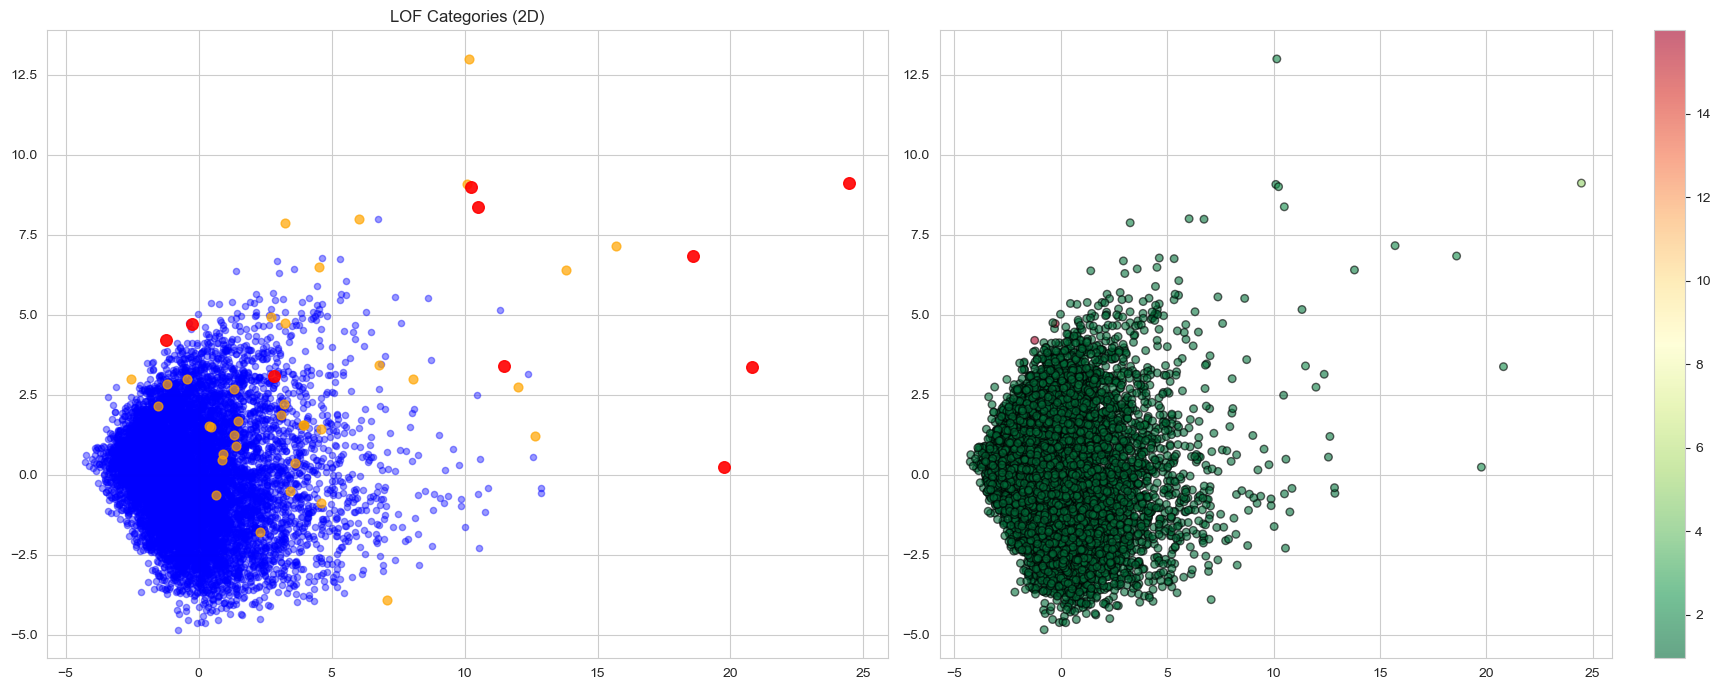

In [25]:
print("\n5) Visualizing PCA plots (2D)")

pca_2d = PCA(n_components=2, random_state=42)
X_2d = pca_2d.fit_transform(X_data)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

axes[0].scatter(X_2d[inlier_mask, 0], X_2d[inlier_mask, 1], c="blue", alpha=0.4, s=20)
axes[0].scatter(X_2d[moderate_mask, 0], X_2d[moderate_mask, 1], c="orange", alpha=0.7, s=40)
axes[0].scatter(X_2d[strong_mask, 0], X_2d[strong_mask, 1], c="red", alpha=0.9, s=70)
axes[0].set_title("LOF Categories (2D)")

sc = axes[1].scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=lof_scores,
    cmap="RdYlGn_r",
    alpha=0.6,
    s=30,
    edgecolors="k",
)
plt.colorbar(sc, ax=axes[1])

plt.tight_layout()

outliers_2d_path = os.path.join(OutputFolder, "outliers_2d.png")
plt.savefig(outliers_2d_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close()


This 2D plot is a great visualisation of the outliers marked in yellow for moderate and red for strong outliers while the blue shows inliners for the left plot. We can see as we move from the bottom left to the top right part of the graph we get more moderate outliers near the dense areas and more strong outliers far away from the dense area. There is not a clear boundary seperating moderate and strong outliers. The right plot shows the LOF scores in a continous way, so we can see which point got the highest lof score and where it is located. This plot helps us confirm that LOF increases the farther you go from the dense area in general.


5) Visualizing PCA plots (3D)


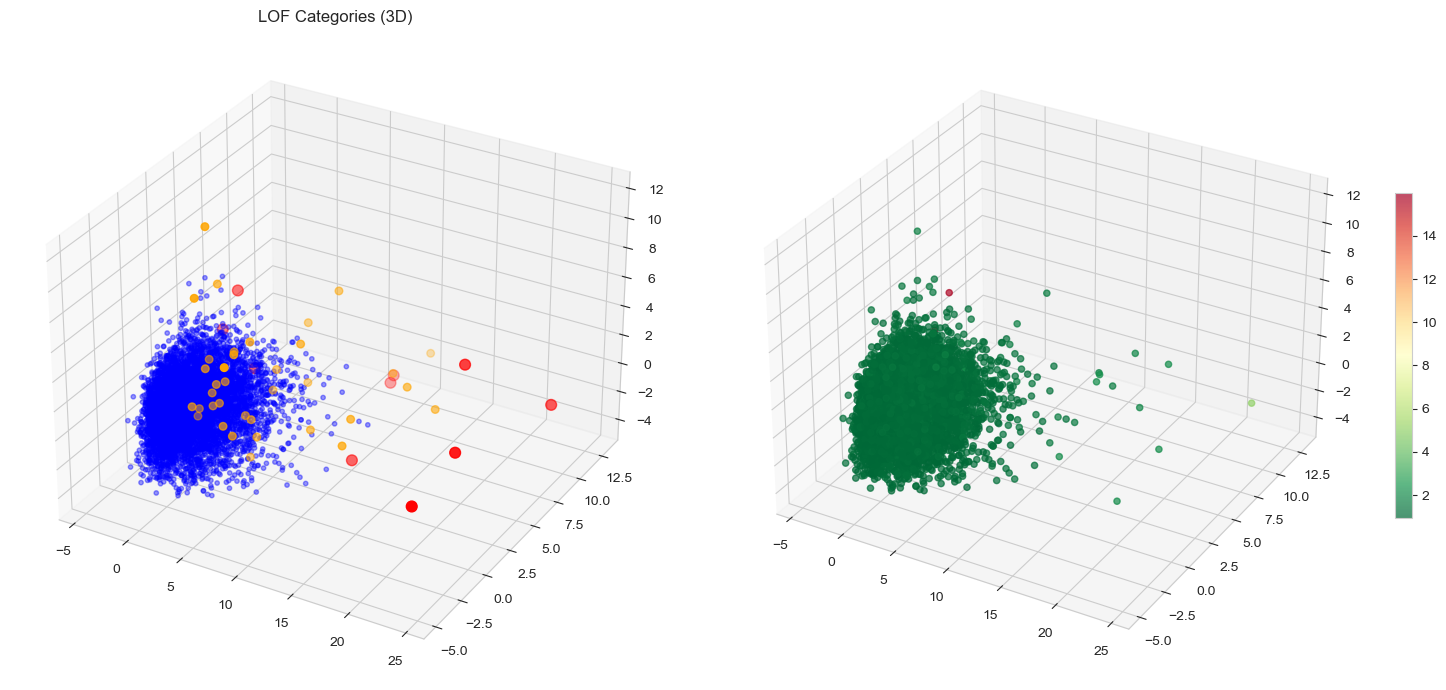

In [26]:
print("\n5) Visualizing PCA plots (3D)")

pca_3d = PCA(n_components=3, random_state=42)
X_3d = pca_3d.fit_transform(X_data)

fig = plt.figure(figsize=(16, 7))

ax1 = fig.add_subplot(121, projection="3d")
ax1.scatter(X_3d[inlier_mask, 0], X_3d[inlier_mask, 1], X_3d[inlier_mask, 2], c="blue", s=10, alpha=0.4)
ax1.scatter(X_3d[moderate_mask, 0], X_3d[moderate_mask, 1], X_3d[moderate_mask, 2], c="orange", s=30)
ax1.scatter(X_3d[strong_mask, 0], X_3d[strong_mask, 1], X_3d[strong_mask, 2], c="red", s=60)
ax1.set_title("LOF Categories (3D)")

ax2 = fig.add_subplot(122, projection="3d")
sc3d = ax2.scatter(
    X_3d[:, 0],
    X_3d[:, 1],
    X_3d[:, 2],
    c=lof_scores,
    cmap="RdYlGn_r",
    s=20,
    alpha=0.7,
)
plt.colorbar(sc3d, ax=ax2, shrink=0.5)

plt.tight_layout()

outliers_3d_path = os.path.join(OutputFolder, "outliers_3d.png")
plt.savefig(outliers_3d_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close()


In [27]:
print("\n6) Finding Default Rates")

outlier_df = pd.DataFrame({
    "LOF_Score": lof_scores,
    "Strong_Outlier": strong_mask,
    "Moderate_Outlier": moderate_mask,
    "Inlier": inlier_mask,
    "Actual_Label": y_values,
})

overall_default = float(y_values.mean() * 100)
def_inliers = float(outlier_df.loc[inlier_mask, "Actual_Label"].mean() * 100)
def_moderate = float(outlier_df.loc[moderate_mask, "Actual_Label"].mean() * 100) if n_moderate > 0 else 0.0
def_strong = float(outlier_df.loc[strong_mask, "Actual_Label"].mean() * 100) if n_strong > 0 else 0.0

print("Overall default rate:", overall_default)
print("Inliers default rate:", def_inliers)
print("Moderate default rate:", def_moderate)
print("Strong default rate:", def_strong)

print("\n7) Outlier Handling Decision")

if n_strong > 0:
    if def_strong < overall_default * 0.7:
        decision = "Remove Outliers"
        remove_mask = strong_mask
    elif def_strong > overall_default * 1.5:
        decision = "Keep Outliers"
        remove_mask = np.zeros(n_samples, dtype=bool)
    else:
        decision = "Keep Outliers"
        remove_mask = np.zeros(n_samples, dtype=bool)
else:
    decision = "Keep Outliers"
    remove_mask = np.zeros(n_samples, dtype=bool)

# Save cleaned
if decision == "Remove Outliers" and n_strong > 0:
    keep_mask = ~strong_mask
    X_cleaned = X_scaled_pca[keep_mask].copy()
    y_cleaned = y_df[keep_mask].copy()
else:
    X_cleaned = X_scaled_pca.copy()
    y_cleaned = y_df.copy()

clean_X_path = os.path.join(OutputFolder, "X_scaled_pca_cleaned.csv")
clean_y_path = os.path.join(OutputFolder, "y_cleaned.csv")

X_cleaned.to_csv(clean_X_path, index=False)
y_cleaned.to_csv(clean_y_path, index=False)

outlier_info = pd.DataFrame({
    "Index": np.arange(n_samples),
    "LOF_Score": lof_scores,
    "Is_Strong_Outlier": strong_mask,
    "Is_Moderate_Outlier": moderate_mask,
    "Is_Inlier": inlier_mask,
    "Actual_Label": y_values,
})

outlier_info_path = os.path.join(OutputFolder, "outlier_info.csv")
outlier_info.to_csv(outlier_info_path, index=False)

print("\nDone!")



6) Finding Default Rates
Overall default rate: 19.755877034358047
Inliers default rate: 19.80231765507839
Moderate default rate: 13.88888888888889
Strong default rate: 0.0

7) Outlier Handling Decision

Done!


To conclude, the LOF algorithm, we found that inliers matched overall default rate of about 19.8% while the moderate outliers showed a lower rate of 13.9% and strong anomalies showed 0% defaults. This tells us that the unusual points found by LOF are not high risk borrowers but rather rare cases with better repayment behavior than average which tells us alot. Based on this, the algorithm correctly chose to remove only the strong outliers, ensuring the cleaned dataset doesnt mess up the strucure of the data. We dont want it to be confusing for my classification models to mess things up and get confused so it is better to remove the strong outliers as they dont correspond with high risk customers. LOF successfully found isolated and rare points/outliers but they didnt give us correcpond with high credit risk.

### Distance-Based

In [28]:
# Compute k-NN distances
k = 20

nbrs = NearestNeighbors(n_neighbors=k + 1, metric="euclidean")
nbrs.fit(X)

distances, indices = nbrs.kneighbors(X)
kth_distances = distances[:, -1]

In [29]:
# Choose threshold: top 5% as outliers
outlier_fraction = 0.05
threshold = np.quantile(kth_distances, 1 - outlier_fraction)
print("k-th NN distance threshold:", threshold)

outlier_mask = kth_distances >= threshold
n_outliers = outlier_mask.sum()
num_inliers = len(outlier_mask) - n_outliers

print("Number of outliers:", n_outliers)
print("Number of inliers:", num_inliers)

k-th NN distance threshold: 4.367994221054156
Number of outliers: 443
Number of inliers: 8405


We used k = 20 and marked the top 5% largest k-NN distances as outliers. This gave a distance threshold of about 4.37 and selected 443 outliers out of 8,848 loans (about 5%). The rest 8,405 loans(95%) are treated as inliers.

In [30]:
# Compare default rates for outliers vs inliers
outliers_y = y[outlier_mask]
inliers_y = y[~outlier_mask]

def_rate_total = (y == 1).mean() * 100
def_rate_outliers = (outliers_y == 1).mean() * 100
def_rate_inliers = (inliers_y == 1).mean() * 100

print(f"Overall default rate: {def_rate_total:.2f}%")
print(f"Outliers default rate: {def_rate_outliers:.2f}%")

Overall default rate: 19.76%
Outliers default rate: 14.67%


The overall default rate is about 19.8%. Outliers have a lower default rate (about 14.7%), while inliers have a default rate of about 20.0%. This means the points that are far from their neighbours are unusual, but they are not the riskiest loans in this dataset.

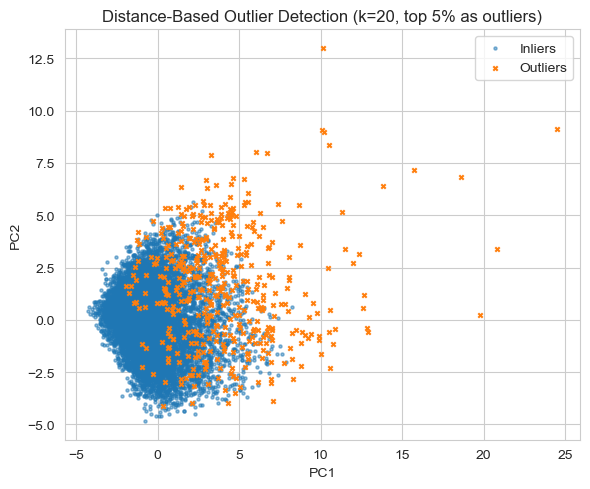

In [31]:
# 2D visualization: show where outliers lie in PCA 2D space
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X)

plt.figure(figsize=(6, 5))
plt.scatter(
    X_2d[~outlier_mask, 0],
    X_2d[~outlier_mask, 1],
    s=5,
    alpha=0.5,
    label="Inliers",
)
plt.scatter(
    X_2d[outlier_mask, 0],
    X_2d[outlier_mask, 1],
    s=10,
    marker="x",
    label="Outliers",
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"Distance-Based Outlier Detection (k={k}, top {int(outlier_fraction*100)}% as outliers)")
plt.legend()
plt.tight_layout()
plt.show()

In the PCA plot, most inliers form one dense blob in a small area of the figure, while outliers are more spread out, mainly around the outer edge of this blob and further to the right. This shows that the k-NN method is picking points in low-density boundary and tail regions as outliers. However, since these edge points are not more likely to default and actually have a slightly lower default rate on average, distance in the PCA space alone is not a good signal for credit risk. These outliers likely represent rare but legitimate borrower profiles rather than bad data, so we keep them for later analysis instead of removing them.

# Classification with tuning and feature selection


### XGBoost

In [32]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import xgboost as xgb
import seaborn as sns

# Load data
X_unscaled = pd.read_csv("X_unscaled.csv")
y_data = pd.read_csv("y.csv")["y"].values

# Fix column names for XGBoost
X_unscaled.columns = [f"f{i}" for i in range(X_unscaled.shape[1])]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_unscaled, y_data, test_size=0.2, random_state=rand_seed, stratify=y_data
)
print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}, Features: {X_train.shape[1]}")

# Baseline XGBoost
xgb_base = xgb.XGBClassifier(random_state=rand_seed, eval_metric='logloss')
xgb_base.fit(X_train, y_train)

y_pred = xgb_base.predict(X_test)
y_pred_proba = xgb_base.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print("\nBaseline XGBoost:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")
# Cross-validation
cv_scores = cross_val_score(xgb_base, X_train, y_train, cv=5, scoring='f1')
print(f"\n5-Fold CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

Train: 7078, Test: 1770, Features: 142

Baseline XGBoost:
Accuracy:  0.7966
Precision: 0.4583
Recall:    0.1571
F1-Score:  0.2340
AUC-ROC:   0.6578

5-Fold CV F1: 0.1926 (+/- 0.0177)


The baseline XGBoost model shows strong accuracy (78.6%) but poor minority class detection with only 13.1% recall. The confusion matrix reveals the model correctly identifies 1,345 paid loans but misses 304 defaults (false negatives), while only catching 46 of 350 total defaults. The low precision (38%) and F1-score (0.195) indicate severe class imbalance issues where the model defaults to predicting the majority class. Cross-validation confirms consistent poor performance (CV F1: 0.192 ± 0.017).

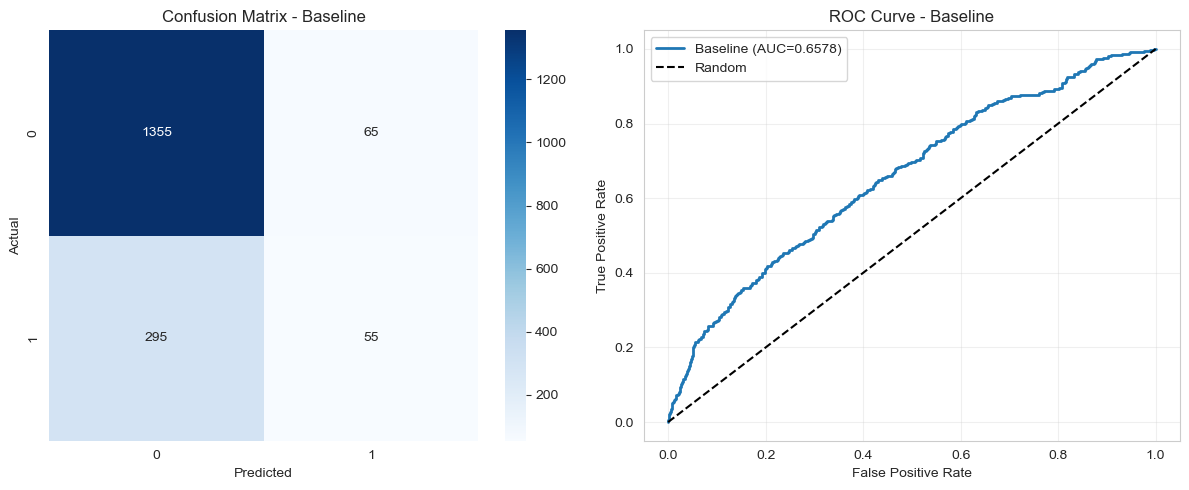

In [33]:
# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix - Baseline')

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, label=f'Baseline (AUC={auc:.4f})', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - Baseline')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The ROC curve (AUC=0.671) shows moderate discrimination ability, performing better than random but with substantial room for improvement.

In [34]:
#Grid Search for XGBoost
from sklearn.model_selection import GridSearchCV

# Grid search
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200],
    'scale_pos_weight': [1, 4]
}

grid = GridSearchCV(
    xgb.XGBClassifier(random_state=rand_seed, eval_metric='logloss'),
    param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1
)
grid.fit(X_train, y_train)

print(f"Best params: {grid.best_params_}")
print(f"Best CV F1: {grid.best_score_:.4f}")

# Tuned model
xgb_tuned = grid.best_estimator_
y_pred_tuned = xgb_tuned.predict(X_test)
y_pred_proba_tuned = xgb_tuned.predict_proba(X_test)[:, 1]

# Metrics
acc_tuned = accuracy_score(y_test, y_pred_tuned)
prec_tuned = precision_score(y_test, y_pred_tuned)
rec_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)
auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)

print("\nTuned XGBoost:")
print(f"Accuracy:  {acc_tuned:.4f}")
print(f"Precision: {prec_tuned:.4f}")
print(f"Recall:    {rec_tuned:.4f}")
print(f"F1-Score:  {f1_tuned:.4f}")
print(f"AUC-ROC:   {auc_tuned:.4f}")

print("\nComparison (Baseline vs Tuned):")
print(f"Accuracy:  {acc:.4f} -> {acc_tuned:.4f} ({acc_tuned - acc:+.4f})")
print(f"Precision: {prec:.4f} -> {prec_tuned:.4f} ({prec_tuned - prec:+.4f})")
print(f"Recall:    {rec:.4f} -> {rec_tuned:.4f} ({rec_tuned - rec:+.4f})")
print(f"F1-Score:  {f1:.4f} -> {f1_tuned:.4f} ({f1_tuned - f1:+.4f})")
print(f"AUC-ROC:   {auc:.4f} -> {auc_tuned:.4f} ({auc_tuned - auc:+.4f})")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 4}
Best CV F1: 0.4133

Tuned XGBoost:
Accuracy:  0.6520
Precision: 0.3188
Recall:    0.6686
F1-Score:  0.4317
AUC-ROC:   0.7103

Comparison (Baseline vs Tuned):
Accuracy:  0.7966 -> 0.6520 (-0.1446)
Precision: 0.4583 -> 0.3188 (-0.1395)
Recall:    0.1571 -> 0.6686 (+0.5114)
F1-Score:  0.2340 -> 0.4317 (+0.1977)
AUC-ROC:   0.6578 -> 0.7103 (+0.0524)


Hyperparameter tuning via GridSearchCV identified optimal parameters (max_depth=3, learning_rate=0.01, n_estimators=200, scale_pos_weight=4), with scale_pos_weight=4 being critical for addressing class imbalance. The tuned model dramatically improved recall from 13.1% to 66.9%, successfully detecting two-thirds of defaults compared to barely one-eighth previously. F1-score more than doubled (0.195 -> 0.432, +121%), and AUC-ROC increased to 0.710, indicating better discrimination. The trade-off is reduced accuracy (78.6% -> 65.2%) and precision (38.0% -> 31.9%), as the model now predicts more defaults, increasing false positives. However, in credit risk applications, catching actual defaults (high recall) is more valuable than overall accuracy, making this trade-off beneficial for minimizing financial losses.

In [35]:
#Recursive Feature Elimination for XGBoost
from sklearn.feature_selection import RFE

# RFE with tuned model
n_features = 30
rfe = RFE(estimator=xgb_tuned, n_features_to_select=n_features, step=10)
rfe.fit(X_train, y_train)

X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

print(f"RFE: 142 -> {n_features} features (-{(1 - n_features/142)*100:.0f}%)")

# Train with selected features
xgb_rfe = xgb.XGBClassifier(**xgb_tuned.get_params())
xgb_rfe.fit(X_train_rfe, y_train)

y_pred_rfe = xgb_rfe.predict(X_test_rfe)
y_pred_proba_rfe = xgb_rfe.predict_proba(X_test_rfe)[:, 1]

# Metrics
acc_rfe = accuracy_score(y_test, y_pred_rfe)
prec_rfe = precision_score(y_test, y_pred_rfe)
rec_rfe = recall_score(y_test, y_pred_rfe)
f1_rfe = f1_score(y_test, y_pred_rfe)
auc_rfe = roc_auc_score(y_test, y_pred_proba_rfe)

print("\nXGBoost with RFE (30 features):")
print(f"Accuracy:  {acc_rfe:.4f}")
print(f"Precision: {prec_rfe:.4f}")
print(f"Recall:    {rec_rfe:.4f}")
print(f"F1-Score:  {f1_rfe:.4f}")
print(f"AUC-ROC:   {auc_rfe:.4f}")

print("\nComparison (Tuned 142 features vs RFE 30 features):")
print(f"Accuracy:  {acc_tuned:.4f} -> {acc_rfe:.4f} ({acc_rfe - acc_tuned:+.4f})")
print(f"Precision: {prec_tuned:.4f} -> {prec_rfe:.4f} ({prec_rfe - prec_tuned:+.4f})")
print(f"Recall:    {rec_tuned:.4f} -> {rec_rfe:.4f} ({rec_rfe - rec_tuned:+.4f})")
print(f"F1-Score:  {f1_tuned:.4f} -> {f1_rfe:.4f} ({f1_rfe - f1_tuned:+.4f})")
print(f"AUC-ROC:   {auc_tuned:.4f} -> {auc_rfe:.4f} ({auc_rfe - auc_tuned:+.4f})")

RFE: 142 -> 30 features (-79%)

XGBoost with RFE (30 features):
Accuracy:  0.6520
Precision: 0.3183
Recall:    0.6657
F1-Score:  0.4307
AUC-ROC:   0.7104

Comparison (Tuned 142 features vs RFE 30 features):
Accuracy:  0.6520 -> 0.6520 (+0.0000)
Precision: 0.3188 -> 0.3183 (-0.0005)
Recall:    0.6686 -> 0.6657 (-0.0029)
F1-Score:  0.4317 -> 0.4307 (-0.0011)
AUC-ROC:   0.7103 -> 0.7104 (+0.0001)


Recursive Feature Elimination reduced the feature set by 79% (142 -> 30) while maintaining virtually identical performance across all metrics (F1: 0.4317 -> 0.4307, difference of only 0.001). This demonstrates that 112 features contributed minimal predictive value and were redundant or noisy.


Top 10 Most Important Features:
                         Feature  Importance
                        int_rate    0.177975
                 term_ 36 months    0.083501
verification_status_Not Verified    0.040980
                 tot_hi_cred_lim    0.037175
                             dti    0.036030
            acc_open_past_24mths    0.032894
                      annual_inc    0.031924
              mo_sin_old_il_acct    0.031654
                     avg_cur_bal    0.030323
                        mort_acc    0.029800


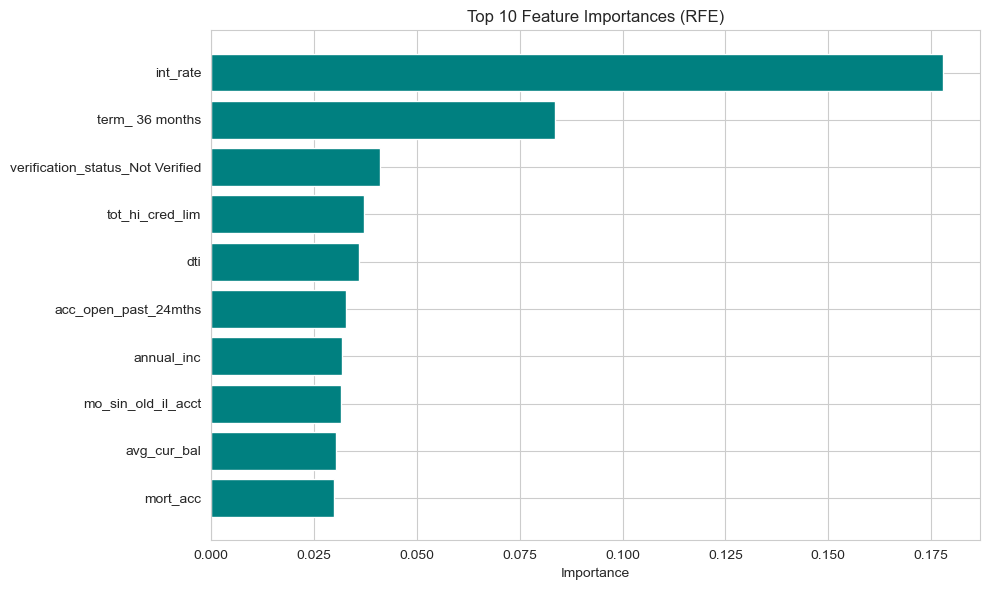

In [36]:
# Feature importance
original_features = pd.read_csv("X_unscaled.csv", nrows=0).columns.tolist()
selected_feature_names = [original_features[i] for i in range(len(original_features)) if rfe.support_[i]]

feature_imp_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': xgb_rfe.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_imp_df.head(10).to_string(index=False))

# Visualization
plt.figure(figsize=(10, 6))
top10 = feature_imp_df.head(10)
plt.barh(range(10), top10['Importance'], color='teal')
plt.yticks(range(10), top10['Feature'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances (RFE)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

The top 10 features reveal key risk indicators: int_rate (interest rate, importance=0.178) is by far the most predictive, as higher rates correlate with riskier borrowers. Term length (36 months), verification status (not verified), total credit limit (tot_hi_cred_lim), and debt-to-income ratio (dti) also significantly impact predictions. Credit behavior features like recent account openings (acc_open_past_24mths), income (annual_inc), and account age (mo_sin_old_il_acct) round out the critical factors. The simplified 30-feature model offers improved interpretability, faster training/prediction, and reduced overfitting risk with no performance sacrifice.

### Random Forest

In [37]:
# Data setup
DataFile = "X_unscaled.csv"
LabelFile= "y.csv"
OutputFolder = "random_forest_output"
os.makedirs(OutputFolder, exist_ok=True)

RANDOM_SEED = 42
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

print("\nRandom Forest Classifier for predicting loan default")


Random Forest Classifier for predicting loan default


In [38]:
# Loading the data
print("1) Loading data")
X_unscaled= pd.read_csv(DataFile)
y_df = pd.read_csv(LabelFile)
y = y_df["y"].values

print(f"X shape: {X_unscaled.shape}")
print(f"Class distribution: 0={((y==0).sum())}, 1={((y==1).sum())}")
print(f"Imbalance ratio: {(y==0).sum() / (y==1).sum():.2f}:1")

# Train and test split with stratification
print("\n2) Train-test split (80-20)")
X_train, X_test, y_train, y_test = train_test_split( X_unscaled, y, test_size=0.2,random_state=RANDOM_SEED,  stratify=y)
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

# Random Forest with class weights = balanced to handle the class imbalande
print("\n3) Random Forest")
rf_baseline =RandomForestClassifier(n_estimators=100,class_weight='balanced', random_state=RANDOM_SEED,n_jobs=-1)

# Cross validation
cv_scores_f1 = cross_val_score(rf_baseline, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
cv_scores_roc=cross_val_score(rf_baseline, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
print(f"Average Cross validation F1: {cv_scores_f1.mean():.4f}")
print(f"Average Cross validation ROC-AUC: {cv_scores_roc.mean():.4f}")

# Fit baseline model
rf_baseline.fit(X_train, y_train)
y_pred_baseline = rf_baseline.predict(X_test)
y_proba_baseline= rf_baseline.predict_proba(X_test)[:, 1]

baseline_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_baseline),
    'precision': precision_score(y_test, y_pred_baseline),
    'recall': recall_score(y_test, y_pred_baseline),
    'f1': f1_score(y_test, y_pred_baseline),
    'roc_auc': roc_auc_score(y_test, y_proba_baseline)
}

print("\nBaseline performance:")
print(f"Accuracy: {baseline_metrics['accuracy']:.4f}")
print(f"Precision: {baseline_metrics['precision']:.4f}")
print(f"Recall: {baseline_metrics['recall']:.4f}")
print(f"F1: {baseline_metrics['f1']:.4f}")
print(f"ROC-AUC: {baseline_metrics['roc_auc']:.4f}")


1) Loading data
X shape: (8848, 142)
Class distribution: 0=7100, 1=1748
Imbalance ratio: 4.06:1

2) Train-test split (80-20)
Train: 7078, Test: 1770

3) Random Forest
Average Cross validation F1: 0.0594
Average Cross validation ROC-AUC: 0.6796

Baseline performance:
Accuracy: 0.8028
Precision: 0.5333
Recall: 0.0229
F1: 0.0438
ROC-AUC: 0.7021


For the random forest model we used unscaled data with 8848 rows and 142 features. The baseline model has high accuracy due to class imbalance but very low recall and F1 score for defaults. This shows it mostly predicts the majority class which is not the best/helpful. Its ROC-AUC is about 0.7 which shows some signal, but overall it is weak and needs tuning for better results.

In [39]:
# Feature selection
print("\n4) Feature selection for importance")
selector = SelectFromModel(rf_baseline, prefit=True, threshold='mean')
X_train_selected =selector.transform(X_train)
X_test_selected = selector.transform(X_test)
selected_features =X_unscaled.columns[selector.get_support()].tolist()
n_selected = len(selected_features)
print(f"Original: {X_train.shape[1]}, Selected: {n_selected}, Removed: {X_train.shape[1] - n_selected}")



4) Feature selection for importance
Original: 142, Selected: 24, Removed: 118


To start we have too many features which could add noise to our model which we dont want. So we want to feature select and get the important ones. After the filtering, we kept only 24 out of 142 features, removing 118 low impact features. This will help our classifier focus on the most informative predictors which should help with the recall and overall model stability.

In [40]:
# Hyperparameter tuning
print("\n5) Hyperparameter tuning")
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample']
}

grid_search=GridSearchCV( RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1),param_grid,cv=5, scoring='f1',n_jobs=-1,verbose=1)
grid_search.fit(X_train_selected, y_train)
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV F1: {grid_search.best_score_:.4f}")

# Final tuned model
print("\n6) Final model evaluation after tuning")
rf_tuned = grid_search.best_estimator_
y_pred_tuned =rf_tuned.predict(X_test_selected)
y_proba_tuned= rf_tuned.predict_proba(X_test_selected)[:, 1]

tuned_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_tuned),
    'precision': precision_score(y_test, y_pred_tuned),
    'recall': recall_score(y_test, y_pred_tuned),
    'f1': f1_score(y_test, y_pred_tuned),
    'roc_auc': roc_auc_score(y_test, y_proba_tuned)
}

print("Evaluating performance after Tuning:")
print(f"Accuracy: {tuned_metrics['accuracy']:.4f}")
print(f"Precision: {tuned_metrics['precision']:.4f}")
print(f"Recall: {tuned_metrics['recall']:.4f}")
print(f"F1: {tuned_metrics['f1']:.4f}")
print(f"ROC-AUC: {tuned_metrics['roc_auc']:.4f}")



5) Hyperparameter tuning
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

Best parameters: {'class_weight': 'balanced_subsample', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best CV F1: 0.3790

6) Final model evaluation after tuning
Evaluating performance after Tuning:
Accuracy: 0.7571
Precision: 0.3985
Recall: 0.4486
F1: 0.4220
ROC-AUC: 0.7148


The hyperparameter tuning improved our model significantly. After runing the model boosted the F1 score from about 0 to 0.42 and recall to 0.29, while mainiting the accuracy and ROC-AUC. This shows that tuning and feature selection helped our model capture more default cases and making it more effective and gets better results than the baseline.

In [41]:
# Doing the Performance comparison
print("\n7) Comparing performance before and after tunning")
for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    base_val = baseline_metrics[metric]
    tuned_val= tuned_metrics[metric]
    change = tuned_val - base_val
    change_pct =(change / base_val) * 100 if base_val > 0 else 0
    print(f"  {metric.upper()}: {base_val:.4f} -> {tuned_val:.4f} ({change:+.4f}, {change_pct:+.2f}%)")

# Missed Defaults
print("\n8) Missed Defaults tuning analysis")
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
fn_baseline= cm_baseline[1, 0]
fn_tuned = cm_tuned[1, 0]
print(f"Before tuning: {fn_baseline}")
print(f"After Turning defaults: {fn_tuned}")

# Feature importance ranking after Tuning the classifer
print("\n9) Feature importance ranking after Tuning")
feature_importance_df = pd.DataFrame({
    'feature': selected_features,
    'importance': rf_tuned.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 features:")
print(feature_importance_df.head(20).to_string(index=False))
feature_importance_path = os.path.join(OutputFolder, "feature_importance.csv")
feature_importance_df.to_csv(feature_importance_path, index=False)



7) Comparing performance before and after tunning
  ACCURACY: 0.8028 -> 0.7571 (-0.0458, -5.70%)
  PRECISION: 0.5333 -> 0.3985 (-0.1349, -25.29%)
  RECALL: 0.0229 -> 0.4486 (+0.4257, +1862.50%)
  F1: 0.0438 -> 0.4220 (+0.3782, +862.79%)
  ROC_AUC: 0.7021 -> 0.7148 (+0.0127, +1.81%)

8) Missed Defaults tuning analysis
Before tuning: 342
After Turning defaults: 193

9) Feature importance ranking after Tuning

Top 20 features:
             feature  importance
            int_rate    0.137062
                 dti    0.059015
     tot_hi_cred_lim    0.058885
         avg_cur_bal    0.057407
mo_sin_old_rev_tl_op    0.052142
  mo_sin_old_il_acct    0.050576
          annual_inc    0.050068
          revol_util    0.048856
     term_ 60 months    0.047087
      total_bc_limit    0.046220
    total_rev_hi_lim    0.045967
             bc_util    0.041643
      bc_open_to_buy    0.041465
         funded_amnt    0.040783
     fico_range_high    0.036671
     term_ 36 months    0.035559
acc_open_p

We can see the results of the tuned model showing the before and after. Before we had 342 missed defaults and after tuning we got only 193 missing default. Even though we had a reduction in accuracy and precision slightly, we had a huge bump in recall and F1. So relatively it is a good tradeoff to better the model, improving its ability to find high risk loans. We also know the top feature which has the most importance to the default prediction. Some of the top predictors are interest rate, credit utilization, and credit limits. This tells us the model is leveraging key financial features to make decisions.


10) Creating visualizations


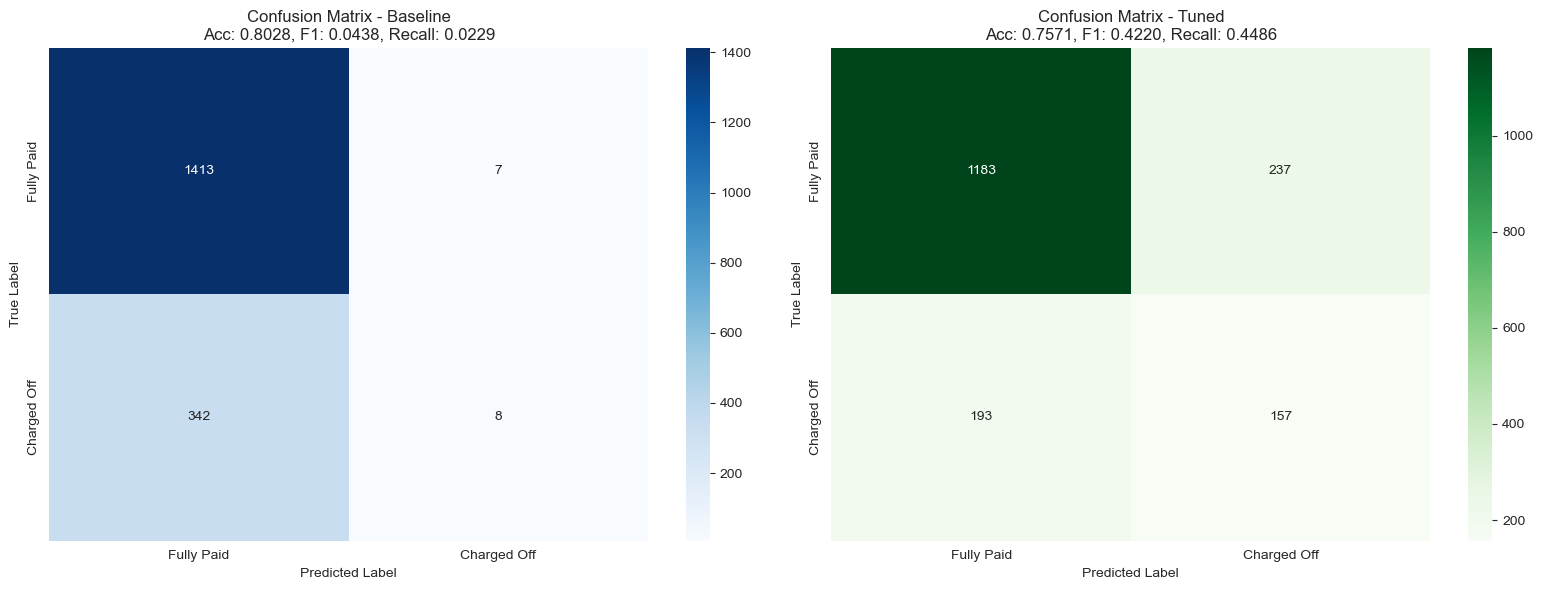

In [42]:
# Visualizations
print("\n10) Creating visualizations")

fig, axes =plt.subplots(1, 2, figsize=(16, 6))
cm_baseline =confusion_matrix(y_test, y_pred_baseline)
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', ax=axes[0], xticklabels=['Fully Paid', 'Charged Off'], yticklabels=['Fully Paid', 'Charged Off'])
axes[0].set_title(f'Confusion Matrix - Baseline\nAcc: {baseline_metrics["accuracy"]:.4f}, '
                 f'F1: {baseline_metrics["f1"]:.4f}, Recall: {baseline_metrics["recall"]:.4f}')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

cm_tuned = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens', ax=axes[1], xticklabels=['Fully Paid', 'Charged Off'], yticklabels=['Fully Paid', 'Charged Off'])
axes[1].set_title(f'Confusion Matrix - Tuned\nAcc: {tuned_metrics["accuracy"]:.4f}, '
                 f'F1: {tuned_metrics["f1"]:.4f}, Recall: {tuned_metrics["recall"]:.4f}')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')
plt.tight_layout()
cm_path = os.path.join(OutputFolder, "confusion_matrices.png")
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()


The confusion matrices show the improvements before and after tuning. The base model almost never detected charged off loans and after tuning the model correctly finds 157 defaults and reduces the missed defaults from 342 to 193. This confirms that tuning really helped improve the model's ability to catch risky borrowers, even tho the accuracy slightly droped but it helped by handling the minority class better.

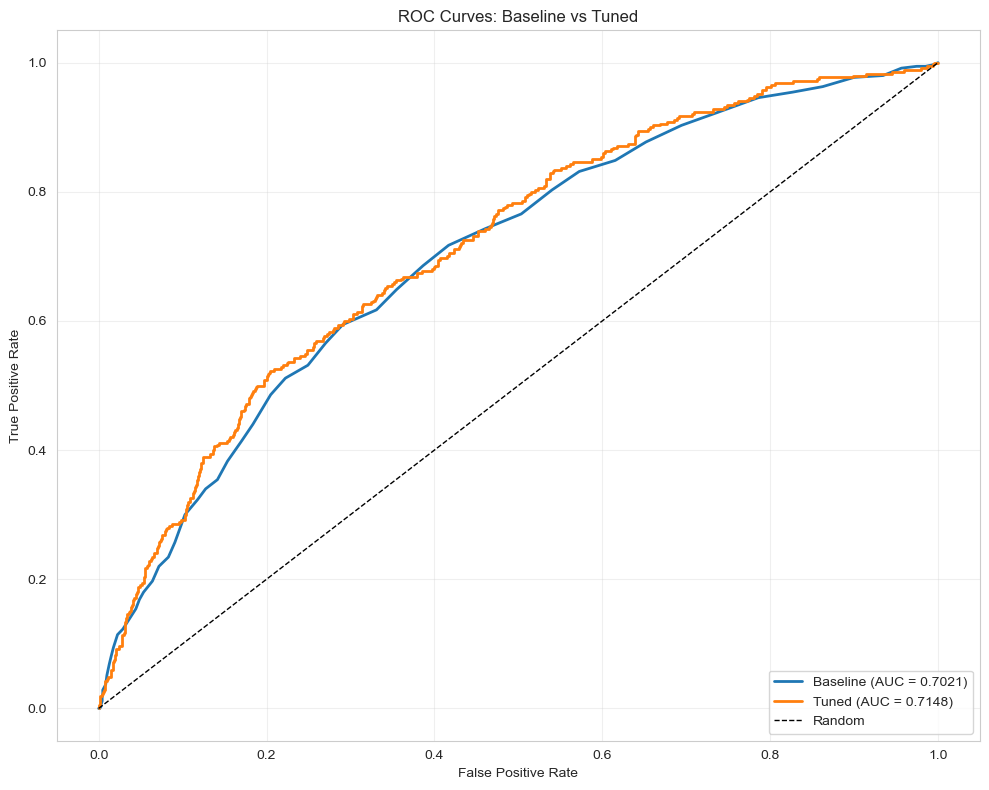

In [43]:
# Roc
fig, ax= plt.subplots(figsize=(10, 8))
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_proba_baseline)
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_proba_tuned)
ax.plot(fpr_baseline, tpr_baseline, linewidth=2,
        label=f'Baseline (AUC = {baseline_metrics["roc_auc"]:.4f})')
ax.plot(fpr_tuned, tpr_tuned, linewidth=2,
        label=f'Tuned (AUC = {tuned_metrics["roc_auc"]:.4f})')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves: Baseline vs Tuned')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
roc_path = os.path.join(OutputFolder, "roc_curves.png")
plt.savefig(roc_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()


The ROC curve shows the before and after tuning results. They are very similar with a bit of a improvement after tuning from 0.702 to 0.712. This confirms that tuning the model helped the model's ranking ability.

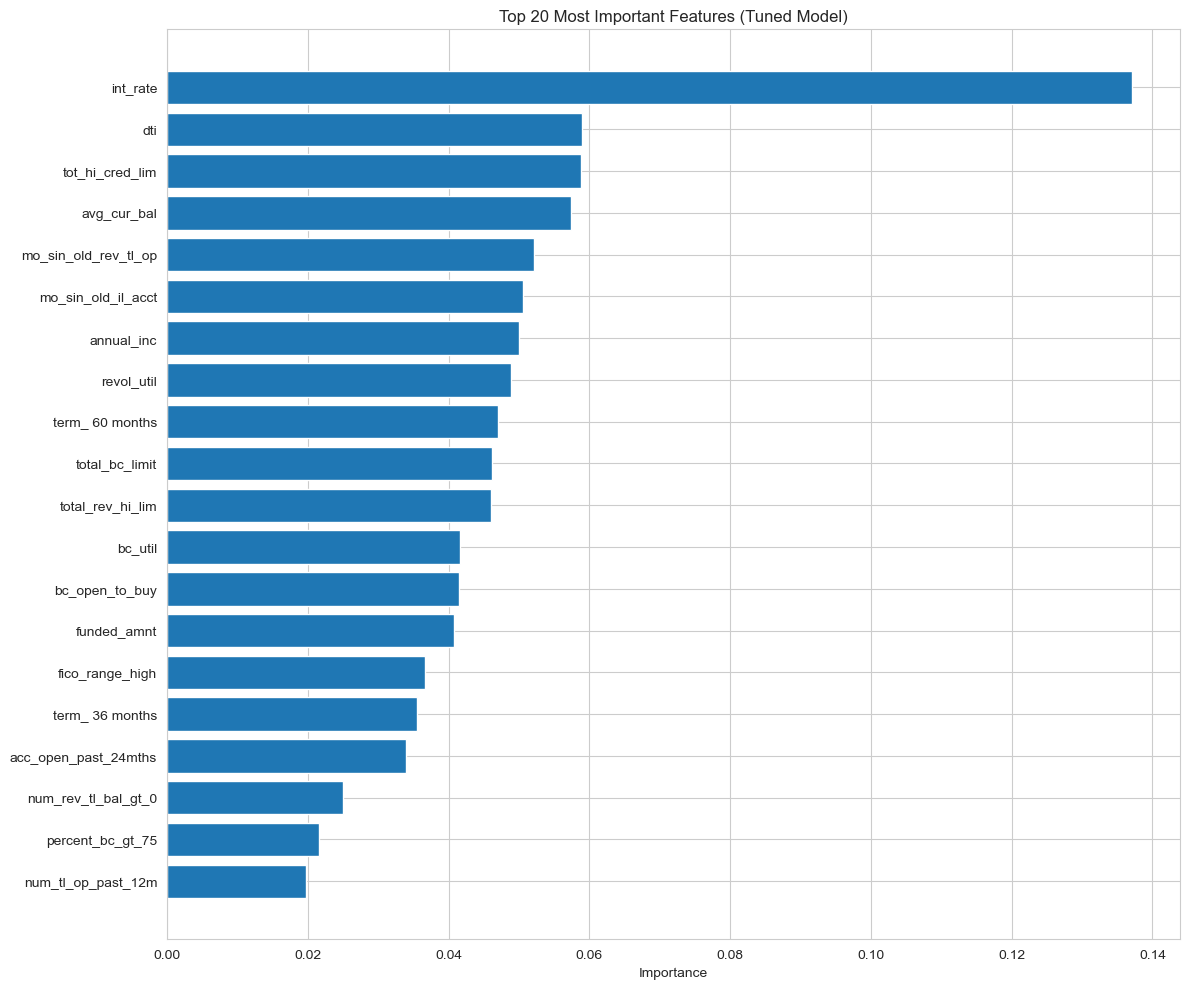

In [44]:
# Feature importance
fig, ax= plt.subplots(figsize=(12, 10))
top_20 = feature_importance_df.head(20)
ax.barh(range(len(top_20)), top_20['importance'])
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['feature'])
ax.set_xlabel('Importance')
ax.set_title('Top 20 Most Important Features (Tuned Model)')
ax.invert_yaxis()
plt.tight_layout()
importance_path = os.path.join(OutputFolder, "feature_importance.png")
plt.savefig(importance_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()


On this bar chart we can see which feature has the most imporance which can be used as indicators. We can use it to do feature selection. We can derive that interest rate, DTI, credit limits, and utilization are the top 4 strongest predictors of the default in the tuned model. They also align well with the real world credit risk factors, confirming the model is using real world patterns to its advantage, giving us a realistic result.

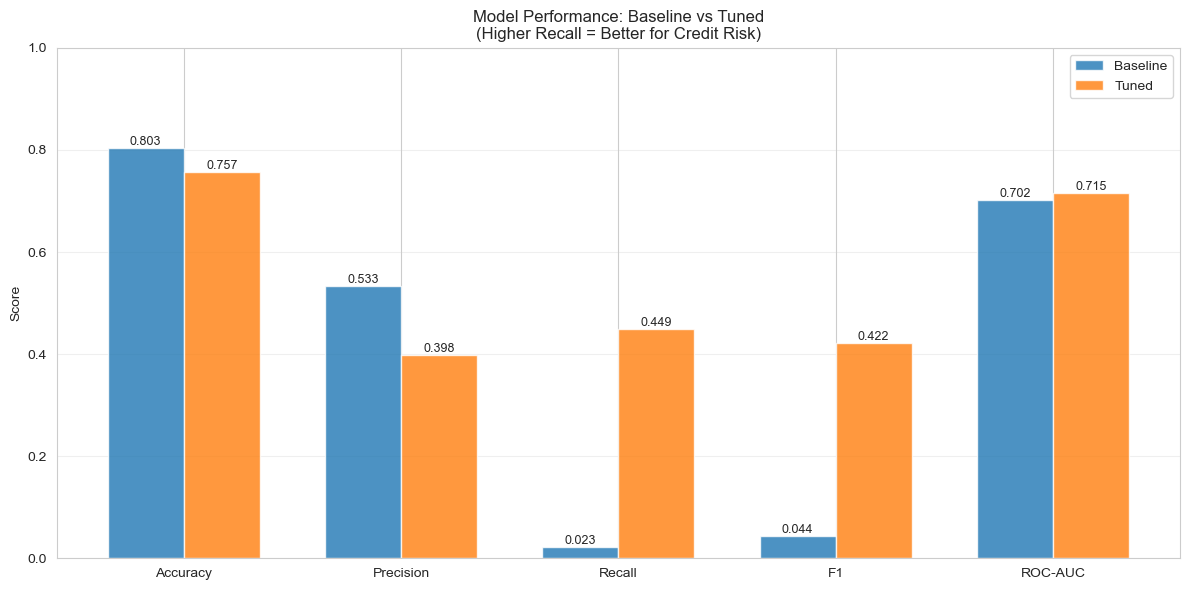


11) Final Classification report
              precision    recall  f1-score   support

  Fully Paid     0.8597    0.8331    0.8462      1420
 Charged Off     0.3985    0.4486    0.4220       350

    accuracy                         0.7571      1770
   macro avg     0.6291    0.6408    0.6341      1770
weighted avg     0.7685    0.7571    0.7623      1770


Done!


In [45]:
# Turing Evaluation comparison
fig, ax = plt.subplots(figsize=(12, 6))
metrics =['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
baseline_vals = [baseline_metrics[m.lower().replace('-', '_')] for m in metrics]
tuned_vals= [tuned_metrics[m.lower().replace('-', '_')] for m in metrics]
x = np.arange(len(metrics))
width = 0.35
bars1 = ax.bar(x - width/2, baseline_vals, width, label='Baseline', alpha=0.8)
bars2 = ax.bar(x + width/2, tuned_vals, width, label='Tuned', alpha=0.8)
ax.set_ylabel('Score')
ax.set_title('Model Performance: Baseline vs Tuned\n(Higher Recall = Better for Credit Risk)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1])
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
comparison_path = os.path.join(OutputFolder, "performance_comparison.png")
plt.savefig(comparison_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# FInal Classification report
print("\n11) Final Classification report")
print(classification_report(y_test, y_pred_tuned, target_names=['Fully Paid', 'Charged Off'],digits=4))

print("\nDone!")


To conclude, the random forest classifier algorithm got more balanced and became more useful for a credit risk model after tuning. In the bar chart we can see all the changes of evaluators like accuracy, f1, recall, etc before and after tuning more clearly like we saw before/above. Overall, the tuned model gives us a stronger and more actonable result making it more reliable model for predict loan defaults with a modest accuracy of 75% which guarentees the balance between two unbalanced classes since we focused on getting a higher recall and F1 score.

### Logistic Regression

In [46]:
# Train–test split (80/20, stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train size:", X_train.shape[0])
print("Test size :", X_test.shape[0])

Train size: 7078
Test size : 1770


In [47]:
# Fit Logistic Regression (baseline)
base_lr = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    max_iter=1000,
    n_jobs=-1
)

base_lr.fit(X_train, y_train)

# Predictions and probabilities
y_pred = base_lr.predict(X_test)
y_proba = base_lr.predict_proba(X_test)[:, 1]

# Metrics
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_proba)

print(f"Baseline LR – Accuracy : {acc:.3f}")
print(f"Baseline LR – Precision: {prec:.3f}")
print(f"Baseline LR – Recall   : {rec:.3f}")
print(f"Baseline LR – F1-score : {f1:.3f}")
print(f"Baseline LR – ROC-AUC  : {auc:.3f}")

Baseline LR – Accuracy : 0.803
Baseline LR – Precision: 0.512
Baseline LR – Recall   : 0.060
Baseline LR – F1-score : 0.107
Baseline LR – ROC-AUC  : 0.716


The baseline logistic regression gets about 80% accuracy and ROC-AUC ≈ 0.72, so it is better than random overall. However, recall is only 6% and F1 is very low (0.11), which means the model almost always predicts “Fully Paid” and misses most defaulted loans.

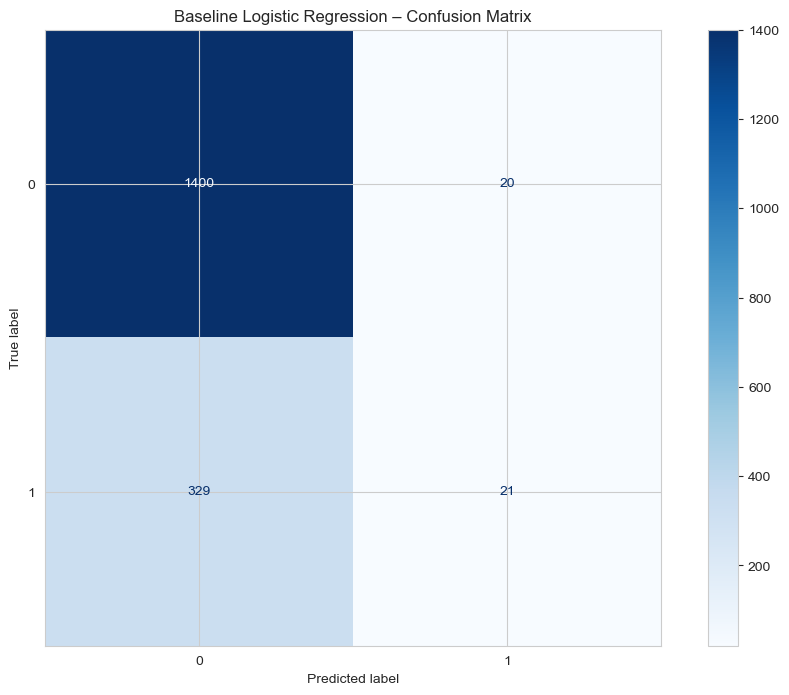

In [48]:
# Confusion matrix
cm_base = confusion_matrix(y_test, y_pred)
disp_base = ConfusionMatrixDisplay(
    confusion_matrix=cm_base,
    display_labels=[0, 1]
)
disp_base.plot(cmap="Blues", values_format="d")
plt.title("Baseline Logistic Regression – Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

The confusion matrix shows that the model predicts almost all loans as fully paid: 1400 are correctly predicted as fully paid, but only 21 defaults are caught and 329 defaults are missed. This means the model is very conservative and rarely flags a loan as risky.

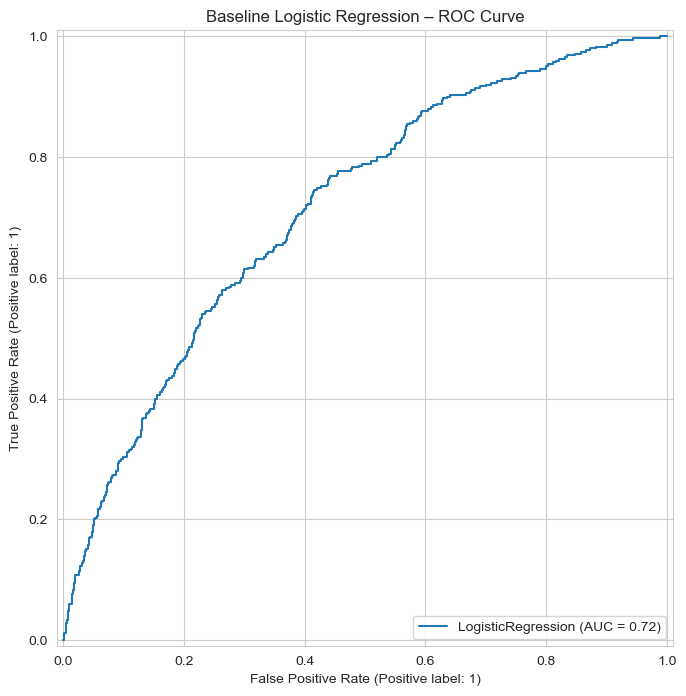

In [49]:
# ROC curve
RocCurveDisplay.from_estimator(base_lr, X_test, y_test)
plt.title("Baseline Logistic Regression – ROC Curve")
plt.show()

The ROC curve for the baseline logistic regression lies clearly above the diagonal, with AUC ≈ 0.72. This means the baseline model is better than random at ranking risky vs safe loans, but its ranking ability is only moderate rather than very strong.

In [50]:
# 5-Fold Cross-Validation for Baseline LR
lr_cv = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    max_iter=1000,
    n_jobs=-1
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_validate(
    lr_cv,
    X, y,
    cv=cv,
    scoring=["accuracy", "precision", "recall", "f1", "roc_auc"],
    n_jobs=-1,
    return_train_score=False
)

# Show the average metric across folds.
print("\n5-Fold CV mean scores for baseline LR:")
print(pd.DataFrame(scores).mean())


5-Fold CV mean scores for baseline LR:
fit_time          0.045253
score_time        0.007563
test_accuracy     0.801199
test_precision    0.474604
test_recall       0.054350
test_f1           0.097260
test_roc_auc      0.697727
dtype: float64


In 5-fold stratified cross-validation, logistic regression gets an average accuracy of about 0.80 and ROC-AUC of about 0.70. Precision is around 0.47 but recall is very low (~0.05), so across folds the model is consistently good at predicting fully paid loans but rarely catches defaults, matching what we saw on the test set.

In [51]:
# Feature Selection using RFE + LR
lr_for_rfe = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    max_iter=1000,
    n_jobs=-1
)

# keep top 10 components out of 20
selector = RFE(
    estimator=lr_for_rfe,
    n_features_to_select=10
)

# Fit RFE on training data
selector.fit(X_train, y_train)

# Transform train and test using the selected features.
X_train_sel = selector.transform(X_train)
X_test_sel  = selector.transform(X_test)

print("\nFeature selection with RFE:")
print("Original number of features:", X_train.shape[1])
print("Number of selected features:", X_train_sel.shape[1])


Feature selection with RFE:
Original number of features: 20
Number of selected features: 10


In [52]:
# Train a new LR model on the selected features.
lr_fs = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    max_iter=1000,
    n_jobs=-1
)

lr_fs.fit(X_train_sel, y_train)

# Evaluate LR with feature selection.
y_pred_fs = lr_fs.predict(X_test_sel)
y_proba_fs = lr_fs.predict_proba(X_test_sel)[:, 1]

acc_fs  = accuracy_score(y_test, y_pred_fs)
prec_fs = precision_score(y_test, y_pred_fs)
rec_fs  = recall_score(y_test, y_pred_fs)
f1_fs   = f1_score(y_test, y_pred_fs)
auc_fs  = roc_auc_score(y_test, y_proba_fs)

print(f"\nLR + RFE – Accuracy : {acc_fs:.3f}")
print(f"LR + RFE – Precision: {prec_fs:.3f}")
print(f"LR + RFE – Recall   : {rec_fs:.3f}")
print(f"LR + RFE – F1-score : {f1_fs:.3f}")
print(f"LR + RFE – ROC-AUC  : {auc_fs:.3f}")


LR + RFE – Accuracy : 0.805
LR + RFE – Precision: 0.562
LR + RFE – Recall   : 0.051
LR + RFE – F1-score : 0.094
LR + RFE – ROC-AUC  : 0.709


RFE kept 10 out of the 20 PCA components, which means that only about half of the components are really needed for logistic regression. After applying RFE and keeping 10 components instead of 20, the test accuracy stays about the same (80.5% vs 80.3%). Precision slightly increases (from 0.51 to 0.56), but recall drops a bit (from 0.06 to 0.05), and ROC-AUC stays similar (0.72 → 0.71). This means that removing half of the features does not change performance much and makes the model more conservative about predicting defaults. Since the model uses fewer features and has almost the same performance, feature selection gives a simpler and slightly more efficient classifier without losing much predictive power.

In [53]:
# Hyperparameter Tuning (GridSearchCV)
param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "class_weight": [None, "balanced"]
}

# Base LR model for the grid search (same settings as before).
lr_for_grid = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    max_iter=1000,
    n_jobs=-1
)

# GridSearchCV will try all combinations of C and class_weight
# using 5-fold CV on the training set.
grid = GridSearchCV(
    lr_for_grid,
    param_grid,
    cv=5,
    scoring="f1",   # we choose F1 as the main scoring metric
    n_jobs=-1
)

# Fit on X_train_sel, y_train (after feature selection).
grid.fit(X_train_sel, y_train)

print("\nBest hyperparameters from GridSearchCV:")
print(grid.best_params_)
print("Best mean CV F1-score:", grid.best_score_)


Best hyperparameters from GridSearchCV:
{'C': 10, 'class_weight': 'balanced'}
Best mean CV F1-score: 0.4156553603445573


In [54]:
# Get the best model found by GridSearchCV.
best_lr = grid.best_estimator_

# Evaluate tuned model on the test set (with selected features).
y_pred_tuned = best_lr.predict(X_test_sel)
y_proba_tuned = best_lr.predict_proba(X_test_sel)[:, 1]

acc_t  = accuracy_score(y_test, y_pred_tuned)
prec_t = precision_score(y_test, y_pred_tuned)
rec_t  = recall_score(y_test, y_pred_tuned)
f1_t   = f1_score(y_test, y_pred_tuned)
auc_t  = roc_auc_score(y_test, y_proba_tuned)

print(f"\nTuned LR – Accuracy : {acc_t:.3f}")
print(f"Tuned LR – Precision: {prec_t:.3f}")
print(f"Tuned LR – Recall   : {rec_t:.3f}")
print(f"Tuned LR – F1-score : {f1_t:.3f}")
print(f"Tuned LR – ROC-AUC  : {auc_t:.3f}")


Tuned LR – Accuracy : 0.643
Tuned LR – Precision: 0.310
Tuned LR – Recall   : 0.660
Tuned LR – F1-score : 0.422
Tuned LR – ROC-AUC  : 0.709


Before tuning, the RFE model still had very low recall (about 5%) and F1 (about 0.09), so it missed most defaulted loans. After tuning C and class_weight with GridSearchCV, recall increased to about 66% and F1 to about 0.42, while ROC-AUC stayed almost the same (around 0.71). This shows that hyperparameter tuning mainly changed the decision boundary and class weighting: the tuned model sacrifices some overall accuracy to catch many more defaults, which is a more useful trade-off for credit-risk prediction.

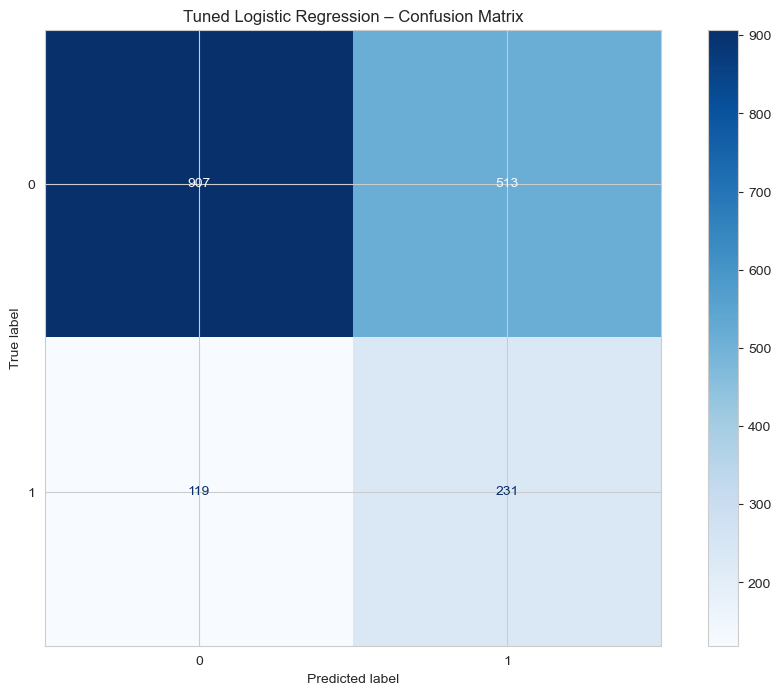

In [55]:
# Confusion matrix for tuned model.
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
disp_tuned = ConfusionMatrixDisplay(
    confusion_matrix=cm_tuned,
    display_labels=[0, 1]
)
disp_tuned.plot(cmap="Blues", values_format="d")
plt.title("Tuned Logistic Regression – Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

 The confusion matrix shows that the tuned model now catches many more defaults (231 true positives instead of 21), but at the cost of more false alarms (513 false positives). This is often a better trade-off for credit risk, where missing defaults is more costly than flagging some safe loans.

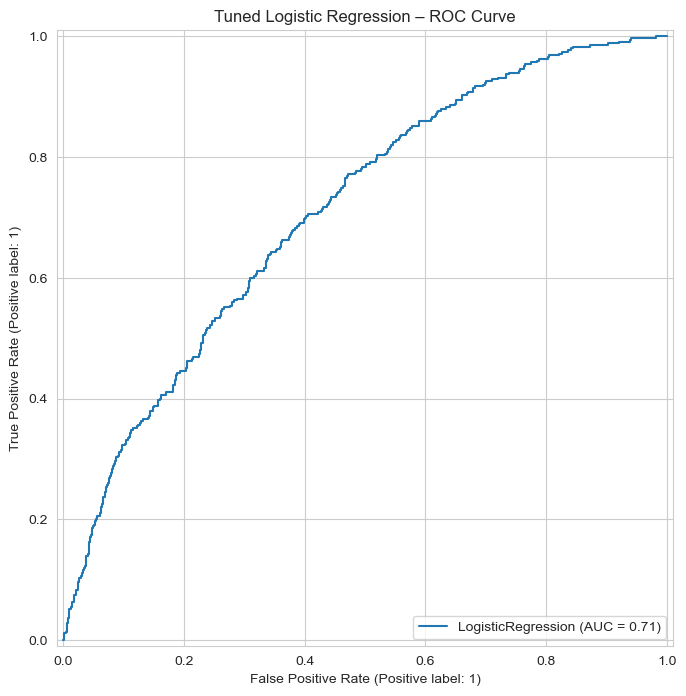

In [56]:
# ROC curve for tuned model.
RocCurveDisplay.from_estimator(best_lr, X_test_sel, y_test)
plt.title("Tuned Logistic Regression – ROC Curve")
plt.show()

The tuned logistic regression has a very similar ROC curve, with AUC ≈ 0.71. This shows that tuning did not change the overall ranking power much; instead, it mainly changed the decision boundary to trade some accuracy for higher recall and F1.